In [1]:
# import all libraries numpy, pandas, matplotlib, seaborn. 

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 900)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df,cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20):
            d_categories['int_cat'].append(col)
        else:
            d_categories['float_ts'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
                        
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(15), labels=df[col].value_counts().head(15).index.str[:15], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False)
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:15], y=target, palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict( marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()
    
# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

In [3]:
df = pd.read_csv('Leads.csv')
df.head(2)
df.shape

Prospect ID  Lead Number Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737         API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728         API   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0        0.000   
1  Organic Search           No          No          0        5.000   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                 0.000  Page Visited on Website   
1                          674                 2.500             Email Opened   

  Country Specialization How did you hear about X Education  \
0     NaN         Select                             Select   
1   India         Select                             Select   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   

                          Tags      Lead Quality  \
0  Interested in other courses  Low in Relevance   
1                      Ringing               NaN   

  Update me on Supply Chain Content Get updates on DM Content Lead Profile  \
0                                No                        No       Select   
1                                No                        No       Select   

     City Asymmetrique Activity Index Asymmetrique Profile Index  \
0  Select                   02.Medium                  02.Medium   
1  Select                   02.Medium                  02.Medium   

   Asymmetrique Activity Score  Asymmetrique Profile Score  \
0                       15.000                      15.000   
1                       15.000                      15.000   

  I agree to pay the amount through cheque  \
0                                       No   
1                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened

(9240, 37)

In [4]:
df.info()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

Prospect ID                                       object
Lead Number                                        int64
Lead Origin                                       object
Lead Source                                       object
Do Not Email                                      object
Do Not Call                                       object
Converted                                          int64
TotalVisits                                      float64
Total Time Spent on Website                        int64
Page Views Per Visit                             float64
Last Activity                                     object
Country                                           object
Specialization                                    object
How did you hear about X Education                object
What is your current occupation                   object
What matters most to you in choosing a course     object
Search                                            object
Magazine                       

In [5]:
100*df.isna().sum()/len(df)
dff =df[(df.notna()).all(axis=1)]
100*dff.isna().sum()

Prospect ID                                      0.000
Lead Number                                      0.000
Lead Origin                                      0.000
Lead Source                                      0.390
Do Not Email                                     0.000
Do Not Call                                      0.000
Converted                                        0.000
TotalVisits                                      1.483
Total Time Spent on Website                      0.000
Page Views Per Visit                             1.483
Last Activity                                    1.115
Country                                         26.634
Specialization                                  15.563
How did you hear about X Education              23.885
What is your current occupation                 29.113
What matters most to you in choosing a course   29.318
Search                                           0.000
Magazine                                         0.000
Newspaper 

Prospect ID                                      0
Lead Number                                      0
Lead Origin                                      0
Lead Source                                      0
Do Not Email                                     0
Do Not Call                                      0
Converted                                        0
TotalVisits                                      0
Total Time Spent on Website                      0
Page Views Per Visit                             0
Last Activity                                    0
Country                                          0
Specialization                                   0
How did you hear about X Education               0
What is your current occupation                  0
What matters most to you in choosing a course    0
Search                                           0
Magazine                                         0
Newspaper Article                                0
X Education Forums             

In [6]:
dff.columns = dff.columns.str.replace(pat=' ',repl='_',regex=True)
dff.columns = dff.columns.str.lower()

In [7]:
sorted([f'{i} - {dff[i].unique()}' for i in dff.columns])

["a_free_copy_of_mastering_the_interview - ['Yes' 'No']",
 "asymmetrique_activity_index - ['02.Medium' '01.High' '03.Low']",
 'asymmetrique_activity_score - [14. 13. 15. 16. 11. 12.  9. 10. 17. 18.  8.]',
 "asymmetrique_profile_index - ['01.High' '02.Medium' '03.Low']",
 'asymmetrique_profile_score - [20. 17. 18. 14. 16. 15. 13. 19. 12.]',
 "city - ['Mumbai' 'Other Metro Cities' 'Select' 'Other Cities' 'Thane & Outskirts'\n 'Other Cities of Maharashtra' 'Tier II Cities']",
 'converted - [1 0]',
 "country - ['India' 'United Arab Emirates' 'United States' 'Bahrain' 'United Kingdom'\n 'Qatar' 'Australia' 'Ghana' 'Singapore' 'Saudi Arabia' 'Kuwait' 'France'\n 'Netherlands' 'Sweden' 'Germany' 'Hong Kong' 'Italy' 'Denmark' 'Canada'\n 'Indonesia' 'South Africa' 'China' 'Bangladesh']",
 "digital_advertisement - ['No' 'Yes']",
 "do_not_call - ['No' 'Yes']",
 "do_not_email - ['No' 'Yes']",
 "get_updates_on_dm_content - ['No']",
 "how_did_you_hear_about_x_education - ['Select' 'Word Of Mouth' 'Ot

In [8]:
numeric_col = ['lead_number','converted','totalvisits','total_time_spent_on_website','page_views_per_visit','asymmetrique_activity_score','asymmetrique_profile_score']
dff[numeric_col].astype('float')
dff.select_dtypes(exclude=[int,float]).dtypes

lead_number  converted  totalvisits  total_time_spent_on_website  \
2      660727.000      1.000        2.000                     1532.000   
3      660719.000      0.000        1.000                      305.000   
4      660681.000      1.000        2.000                     1428.000   
6      660673.000      1.000        2.000                     1640.000   
10     660608.000      1.000        8.000                     1351.000   
...           ...        ...          ...                          ...   
9234   579615.000      1.000        5.000                      210.000   
9235   579564.000      1.000        8.000                     1845.000   
9236   579546.000      0.000        2.000                      238.000   
9237   579545.000      0.000        2.000                      199.000   
9239   579533.000      1.000        6.000                     1279.000   

      page_views_per_visit  asymmetrique_activity_score  \
2                    2.000                       14.000   
3                    1.000                       13.000   
4                    1.000                       15.000   
6                    2.000                       14.000   
10                   8.000                       15.000   
...                    ...                          ...   
9234                 2.500                       14.000   
9235                 2.670                       15.000   
9236                 2.000                       14.000   
9237                 2.000                       13.000   
9239                 3.000                       15.000   

      asymmetrique_profile_score  
2                         20.000  
3                         17.000  
4                         18.000  
6                         20.000  
10                        14.000  
...                          ...  
9234                      20.000  
9235                      17.000  
9236                      19.000  
9237                      20.000  
9239                      18.000  

[1943 rows x 7 columns]

prospect_id                                      object
lead_origin                                      object
lead_source                                      object
do_not_email                                     object
do_not_call                                      object
last_activity                                    object
country                                          object
specialization                                   object
how_did_you_hear_about_x_education               object
what_is_your_current_occupation                  object
what_matters_most_to_you_in_choosing_a_course    object
search                                           object
magazine                                         object
newspaper_article                                object
x_education_forums                               object
newspaper                                        object
digital_advertisement                            object
through_recommendations                         

In [9]:
dff.shape

(1943, 37)

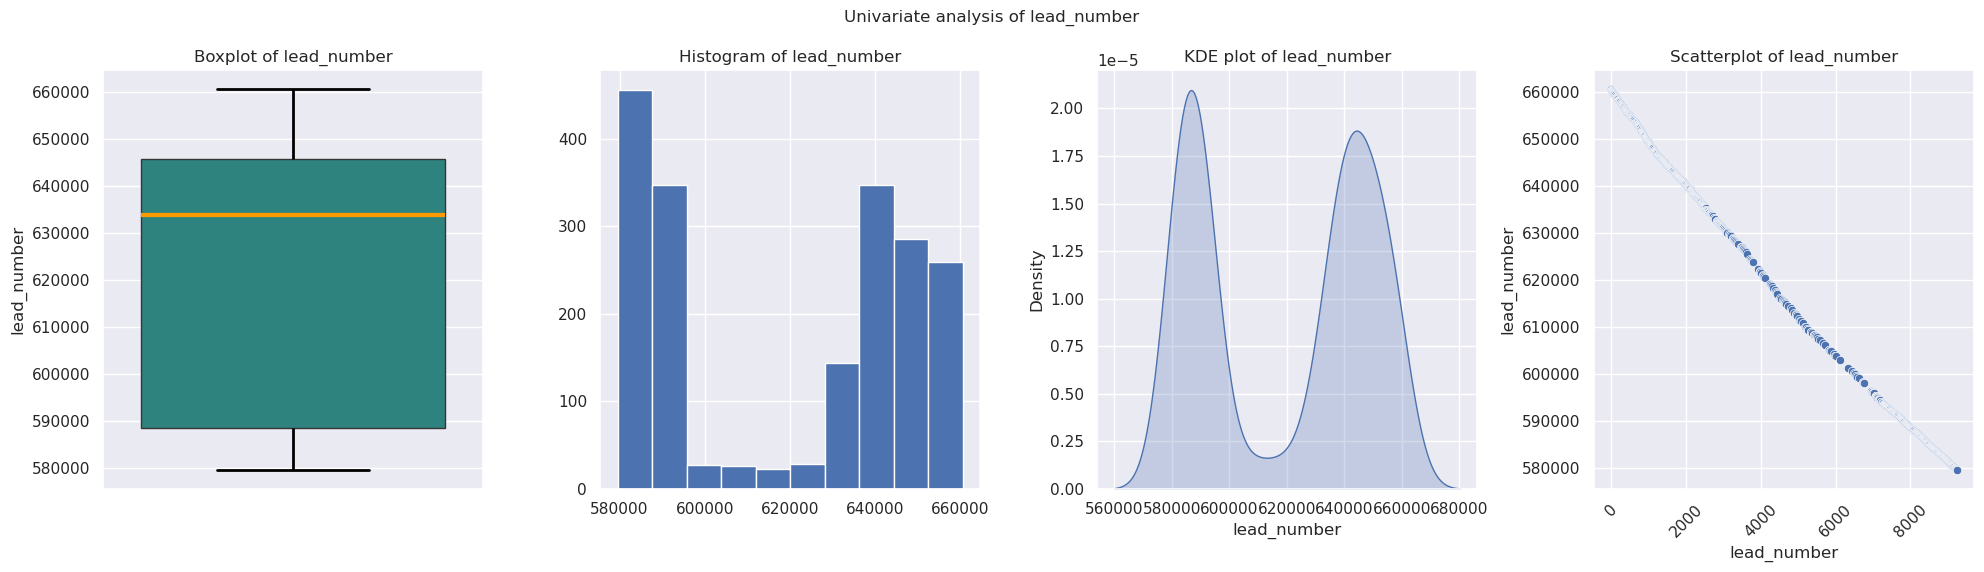

<Figure size 640x480 with 0 Axes>

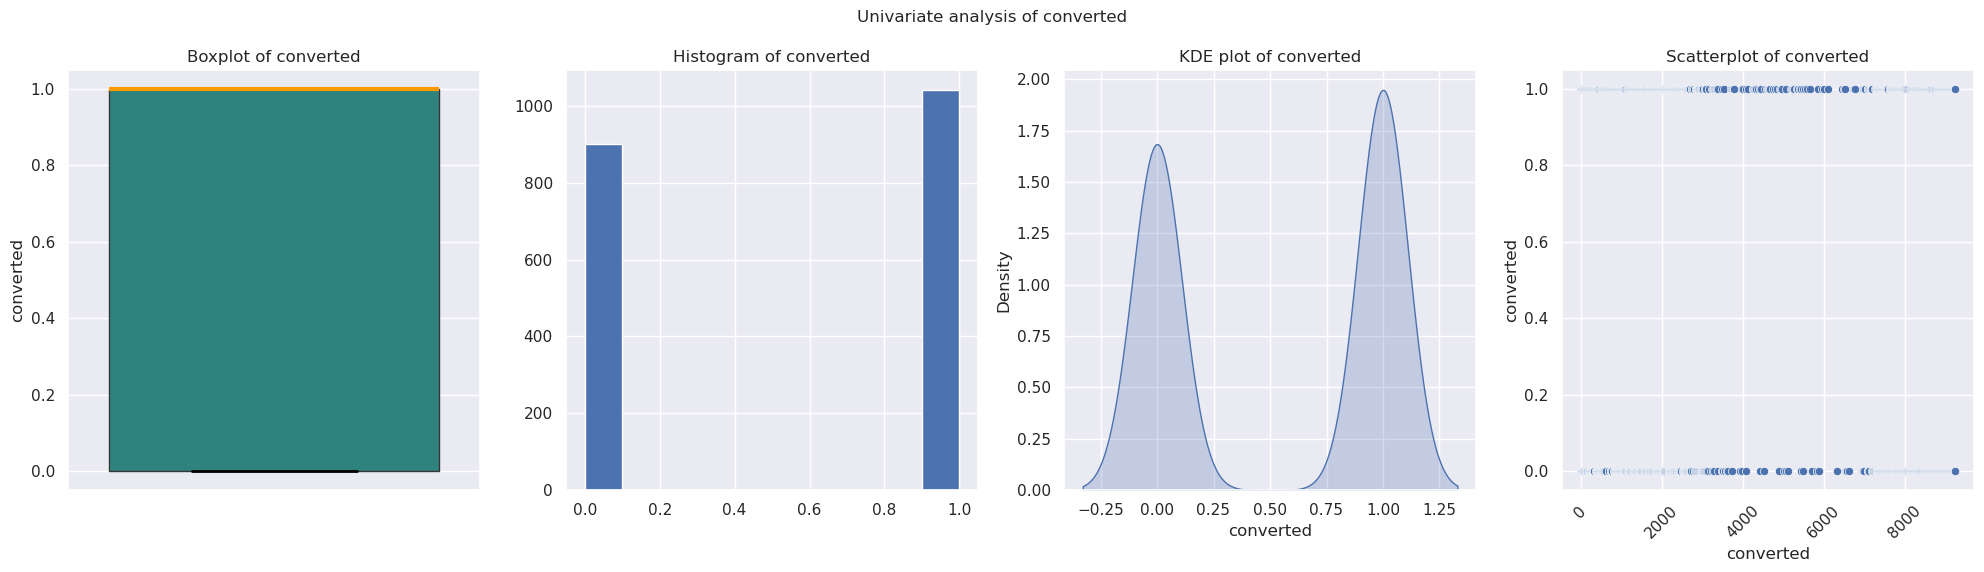

<Figure size 640x480 with 0 Axes>

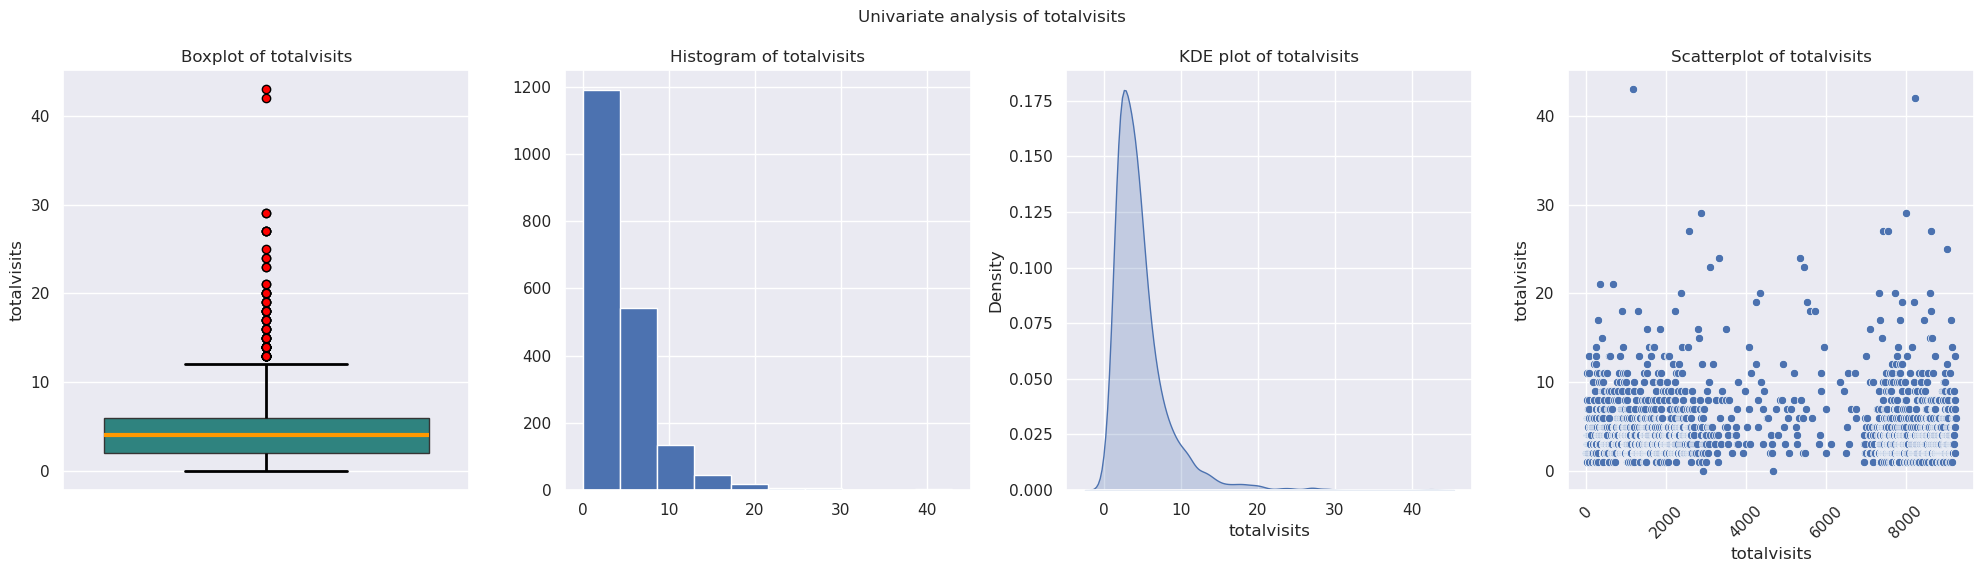

<Figure size 640x480 with 0 Axes>

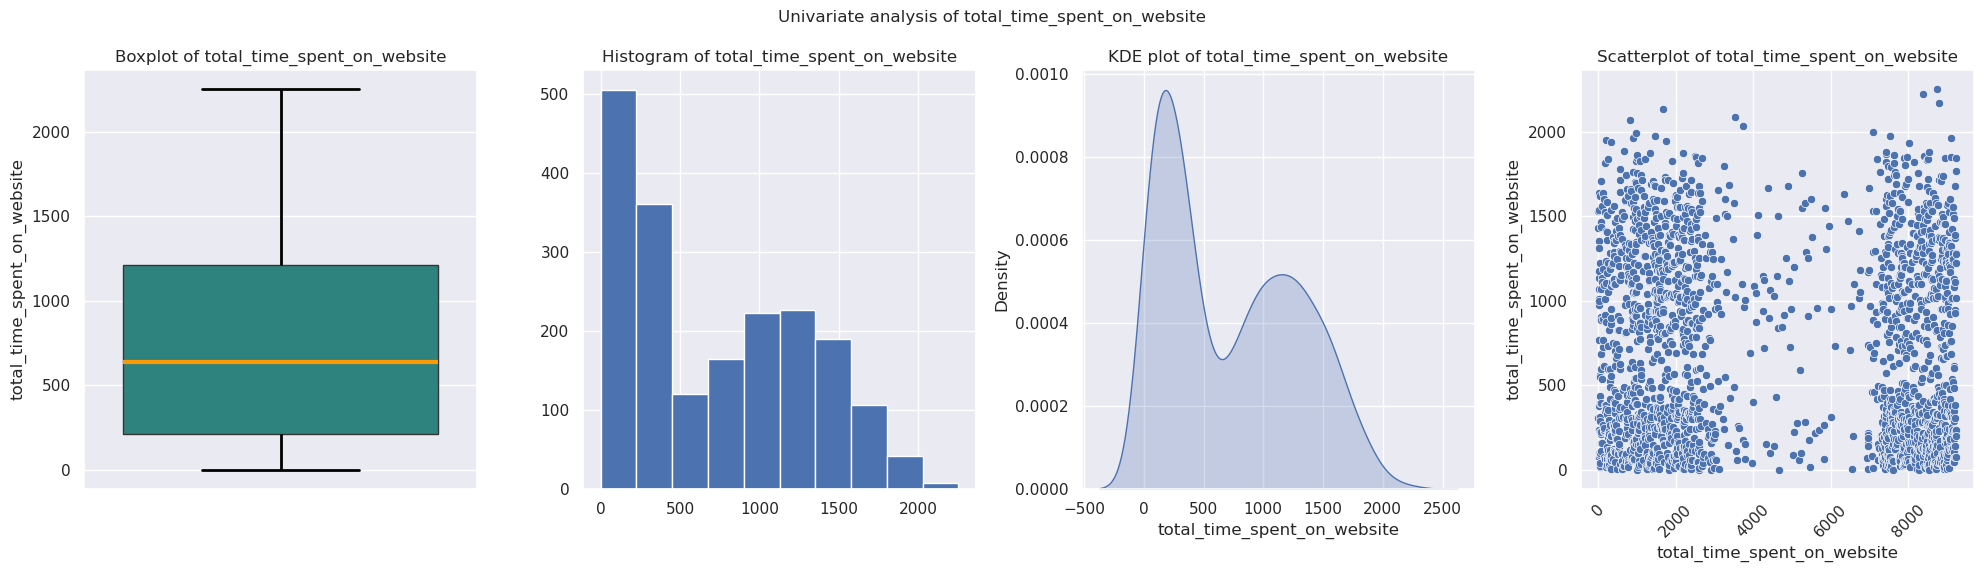

<Figure size 640x480 with 0 Axes>

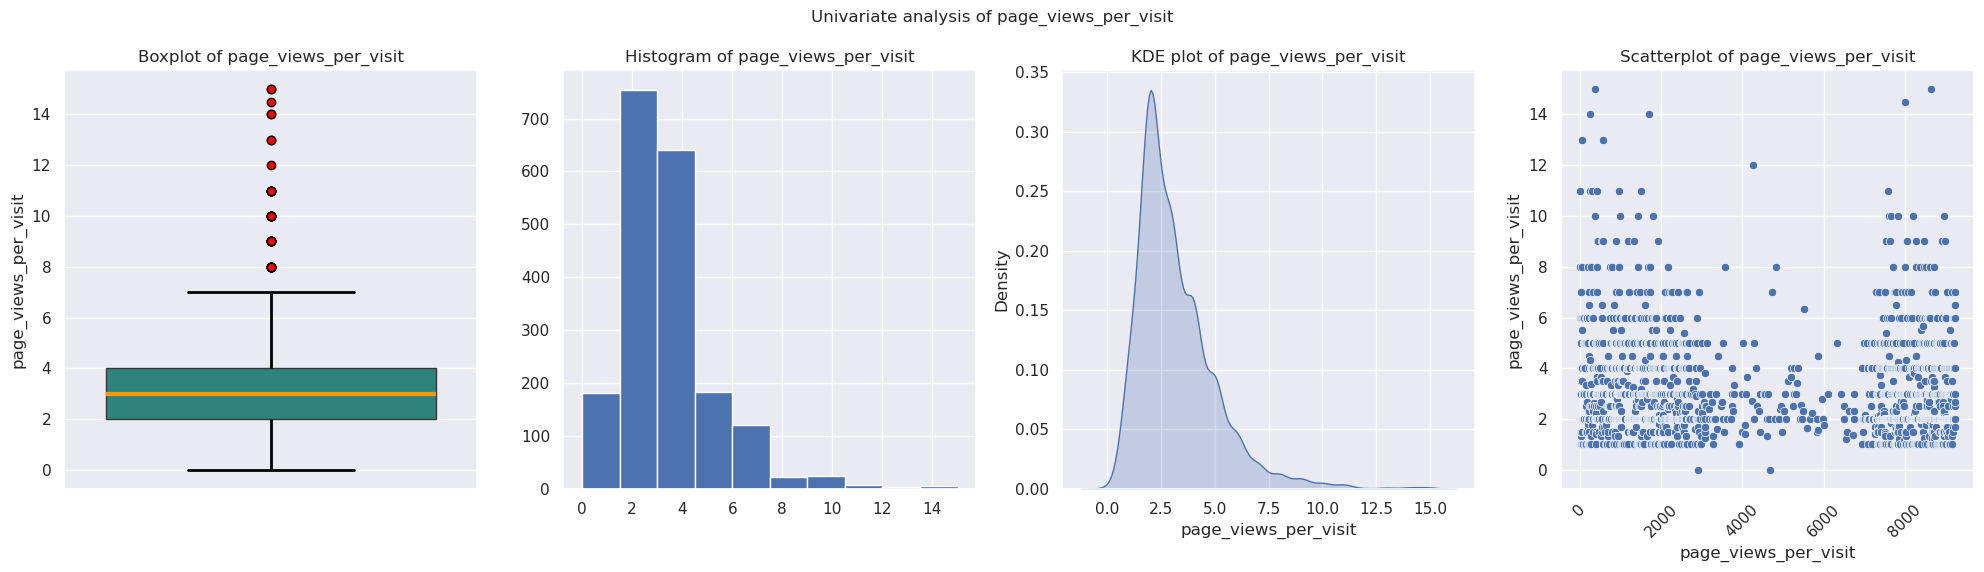

<Figure size 640x480 with 0 Axes>

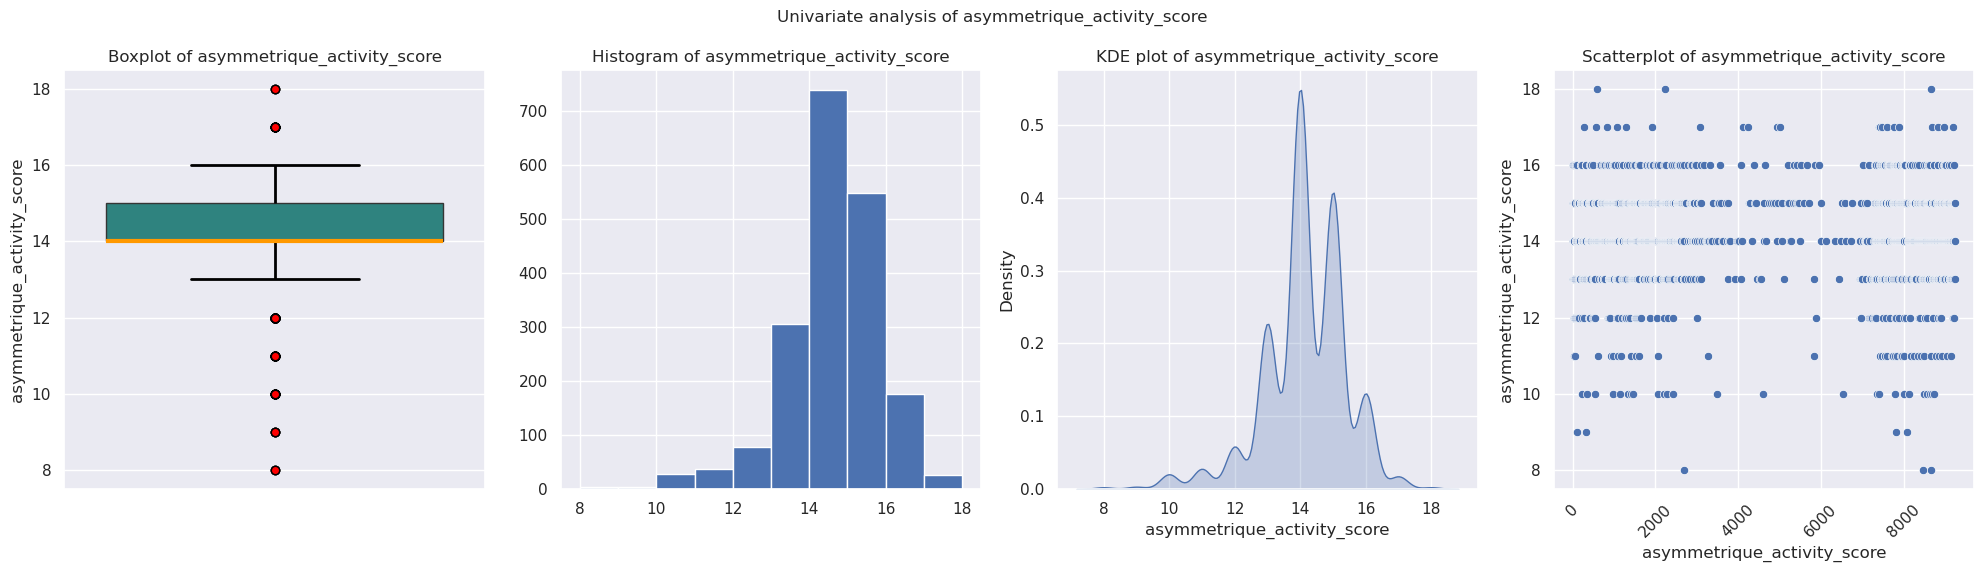

<Figure size 640x480 with 0 Axes>

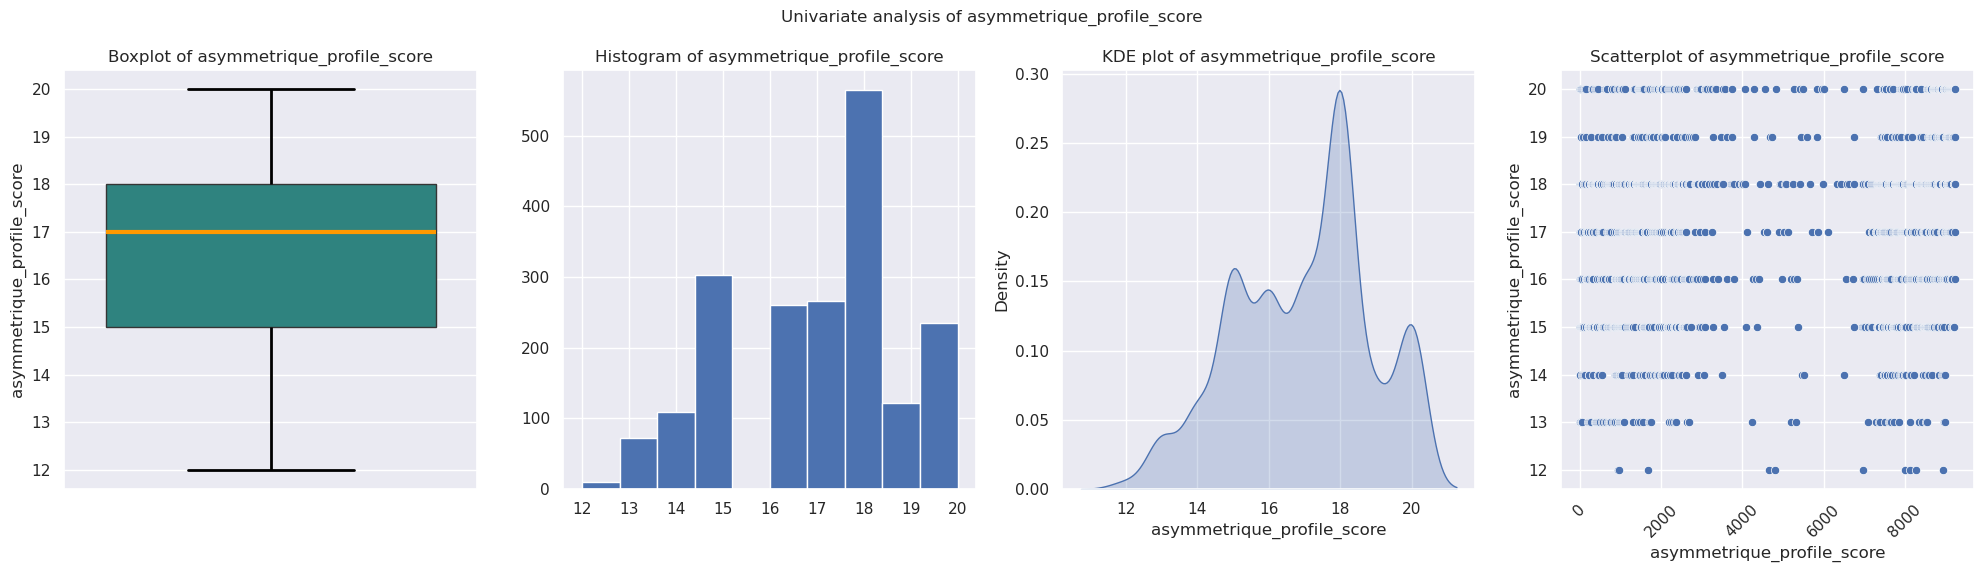

<Figure size 640x480 with 0 Axes>

In [10]:
univariate_plots(dff, dff.select_dtypes(include=[int,float]).columns, ftype='non_categorical')

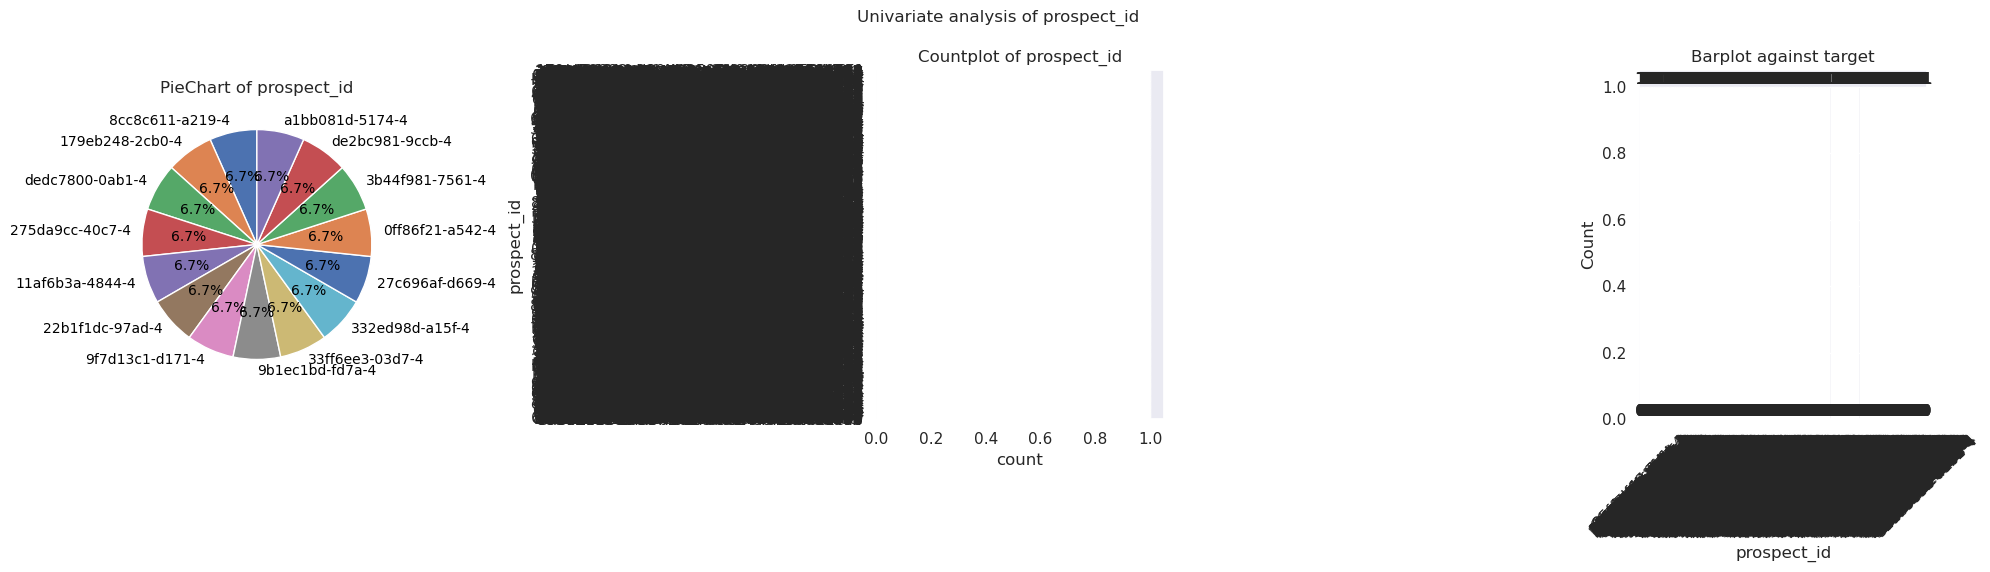

<Figure size 640x480 with 0 Axes>

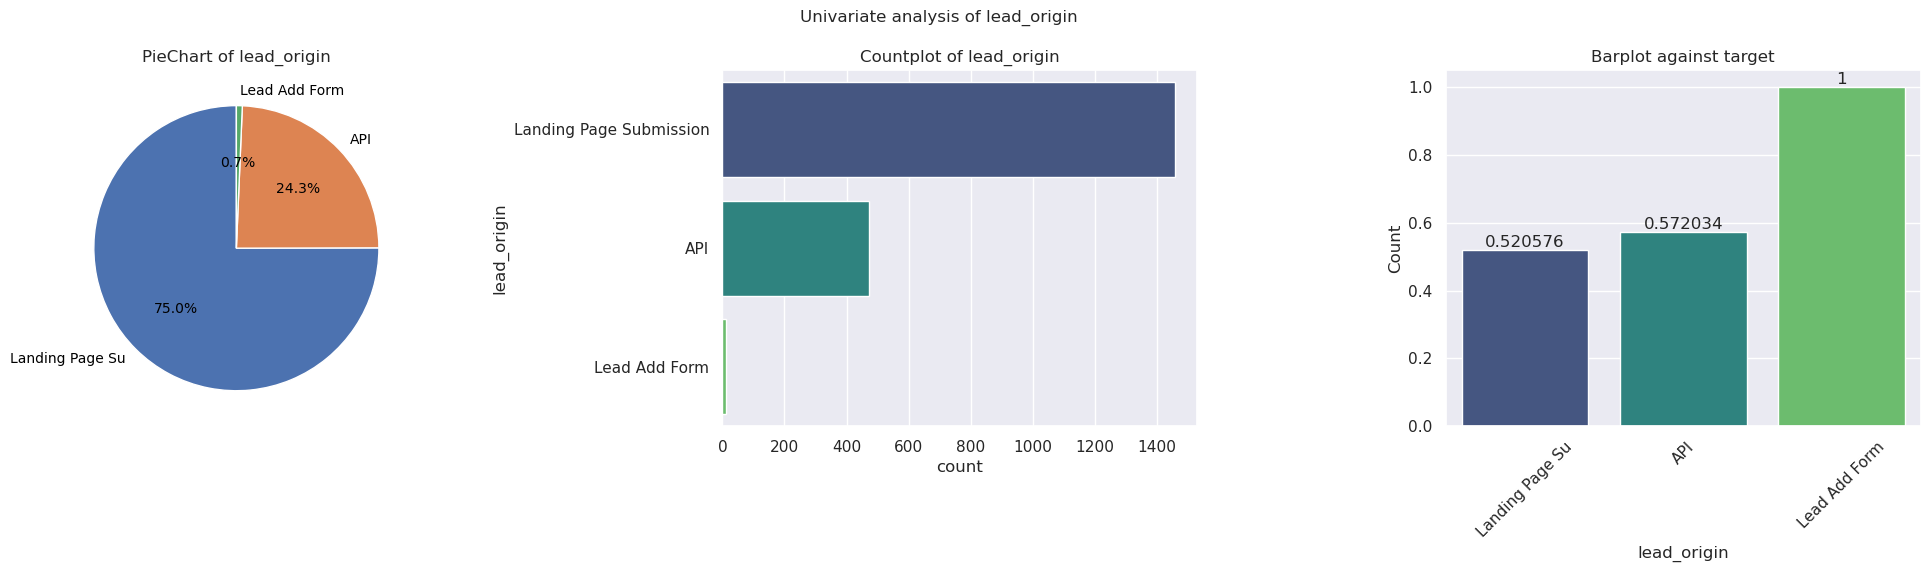

<Figure size 640x480 with 0 Axes>

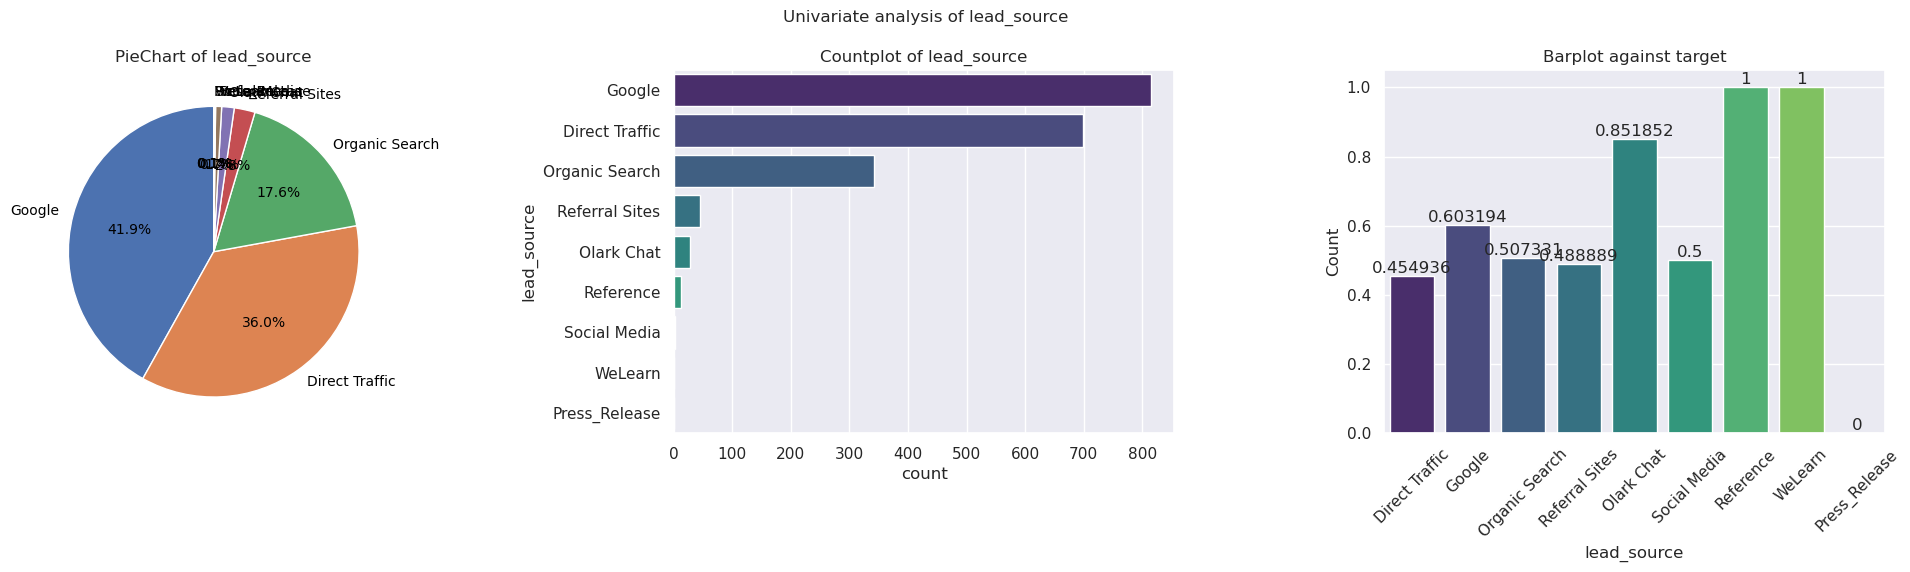

<Figure size 640x480 with 0 Axes>

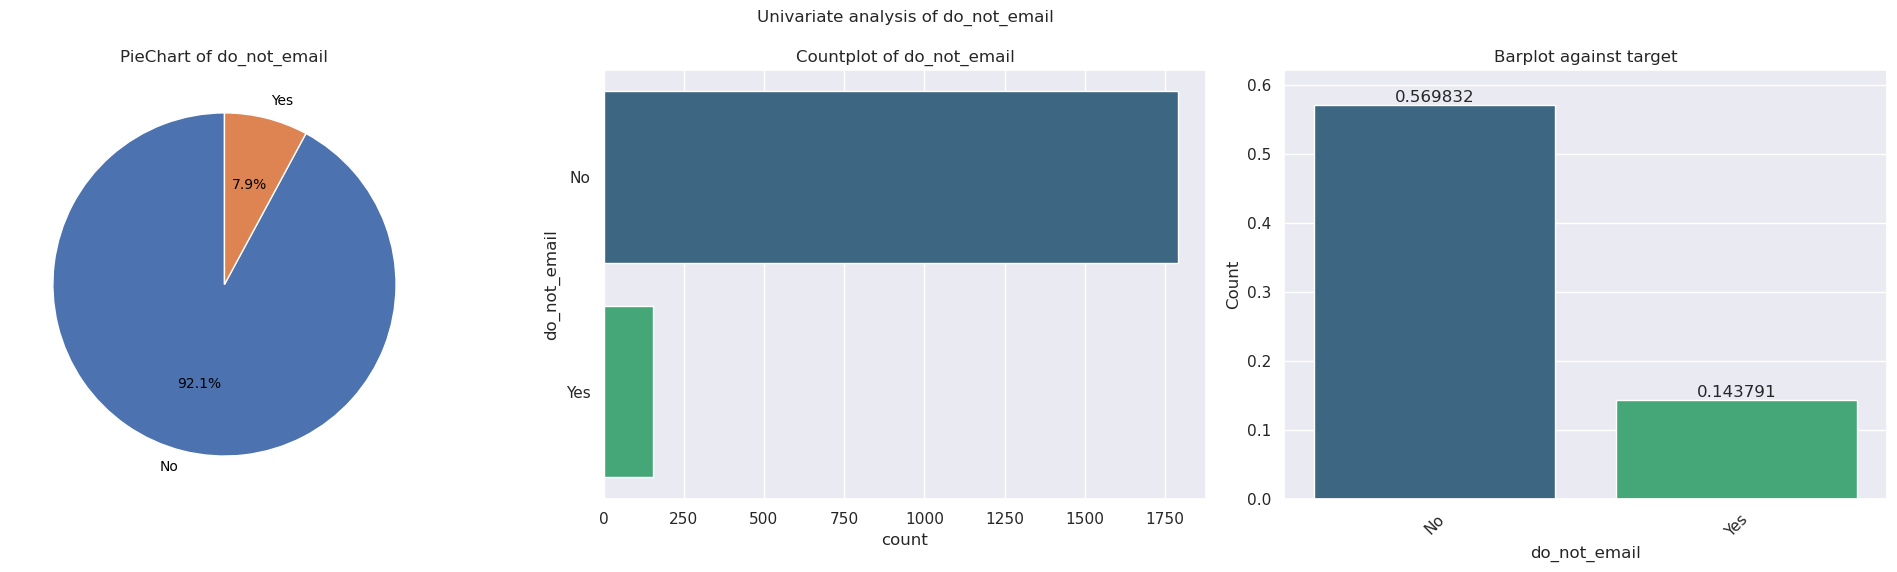

<Figure size 640x480 with 0 Axes>

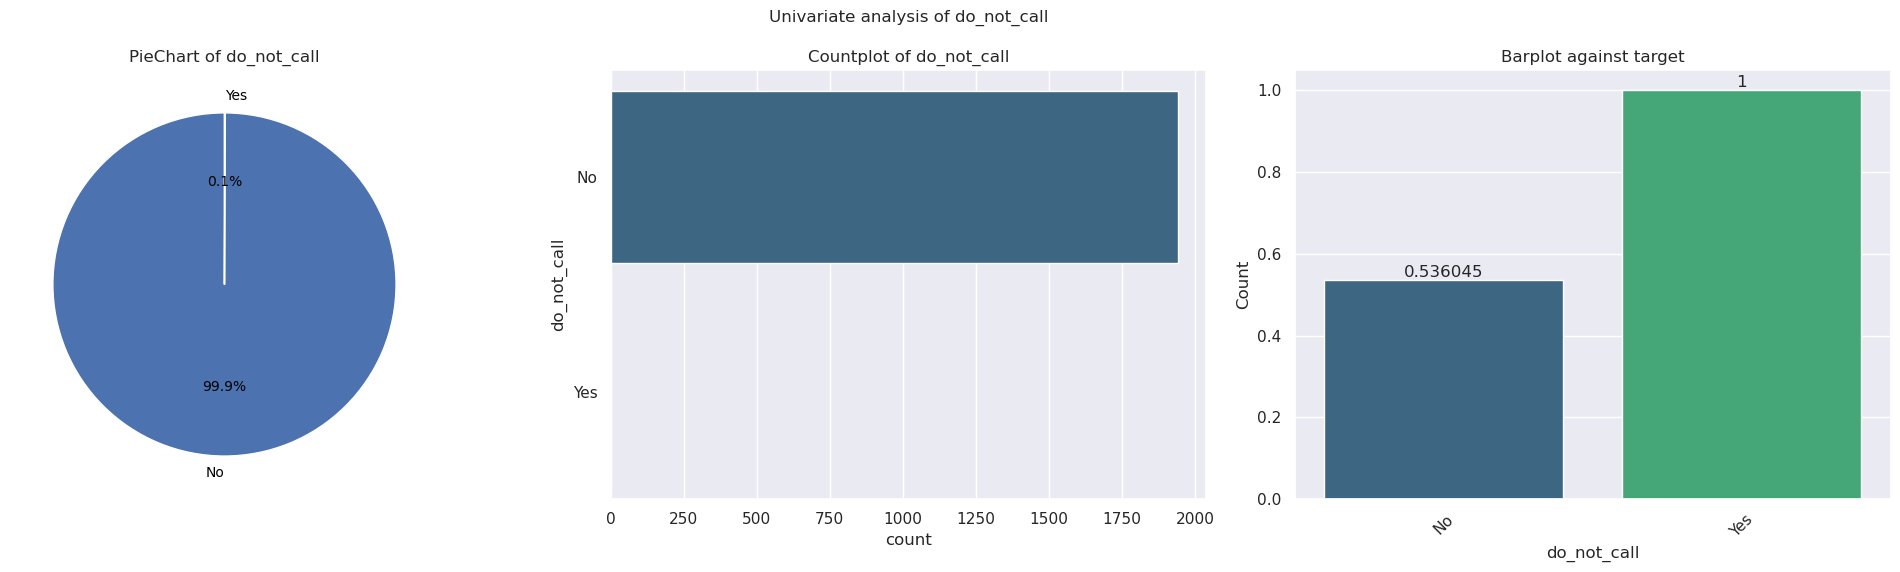

<Figure size 640x480 with 0 Axes>

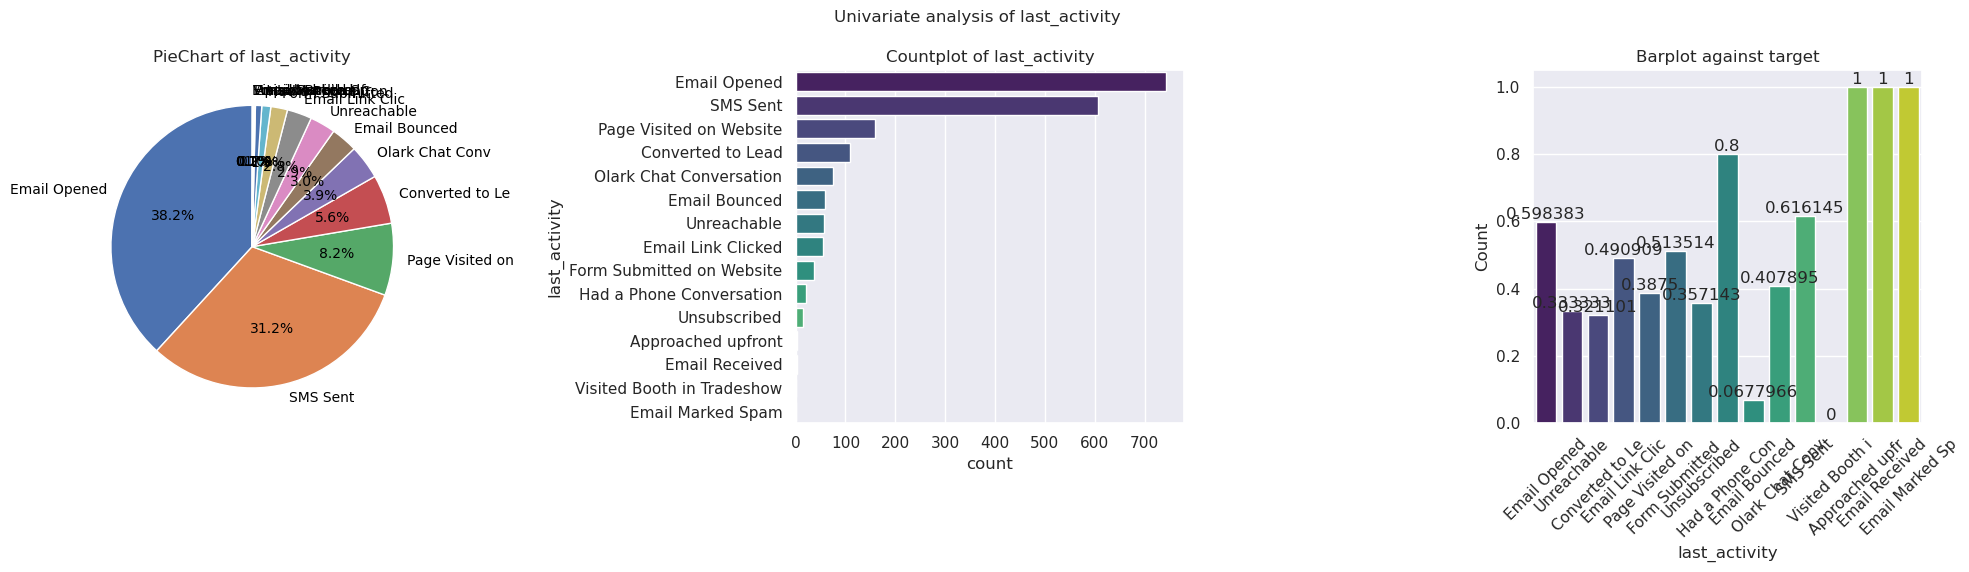

<Figure size 640x480 with 0 Axes>

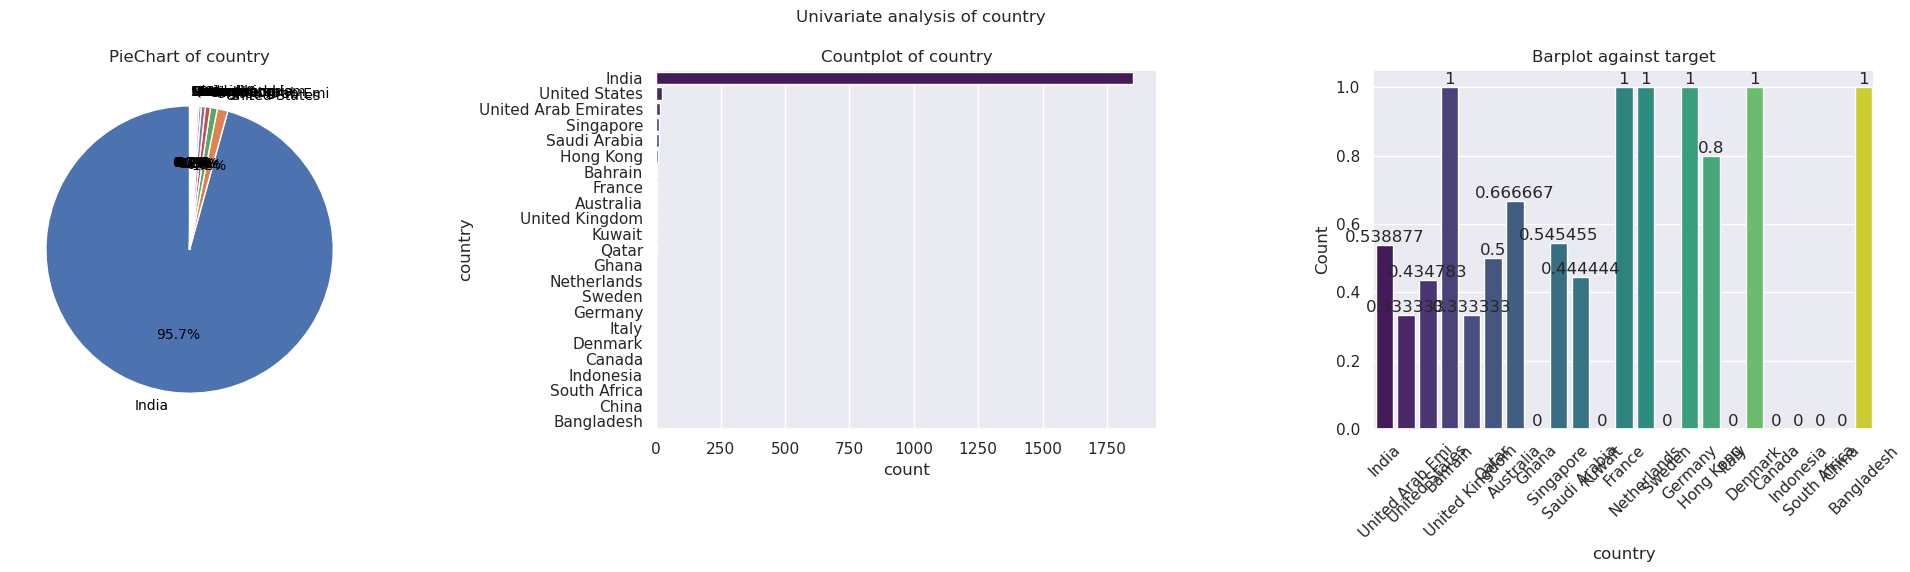

<Figure size 640x480 with 0 Axes>

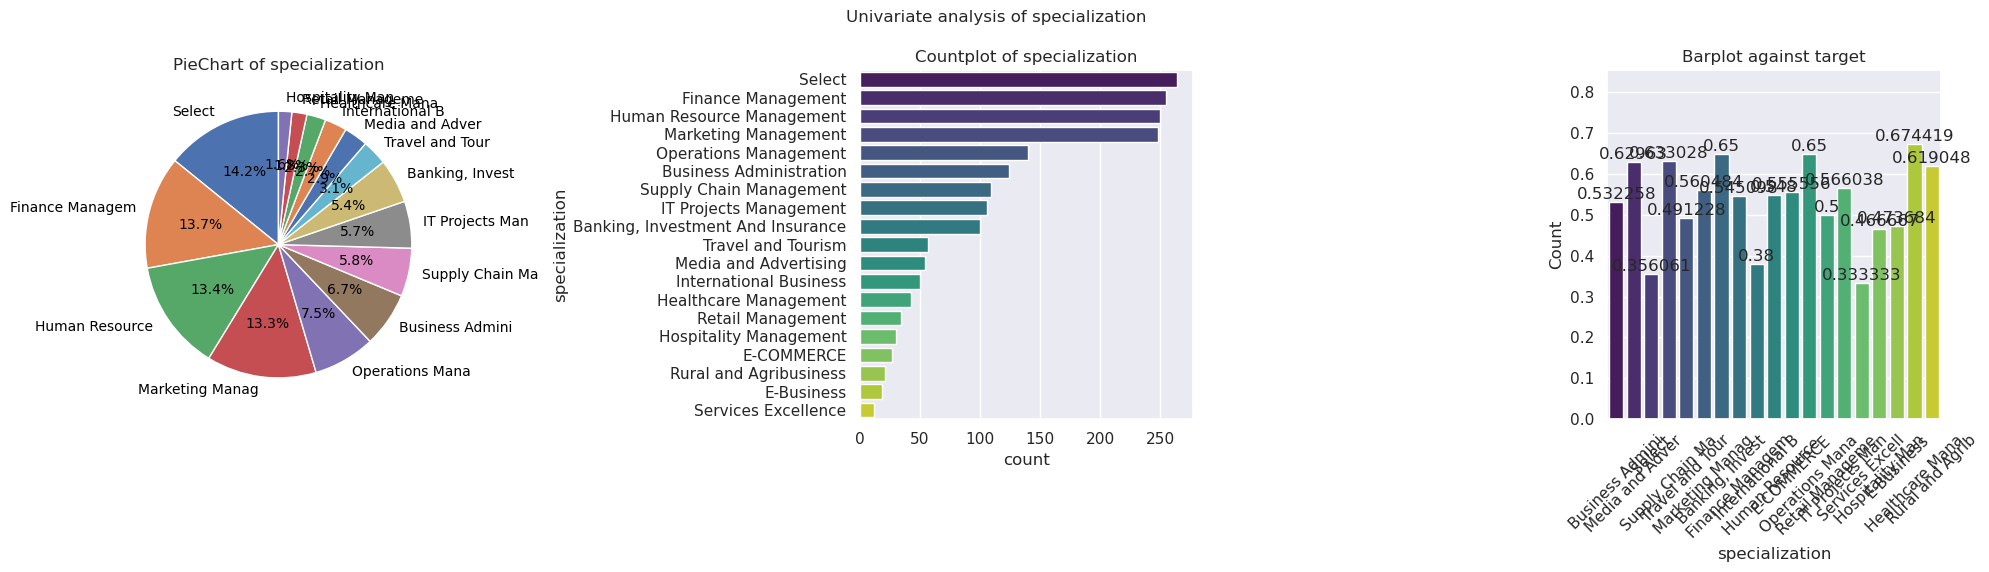

<Figure size 640x480 with 0 Axes>

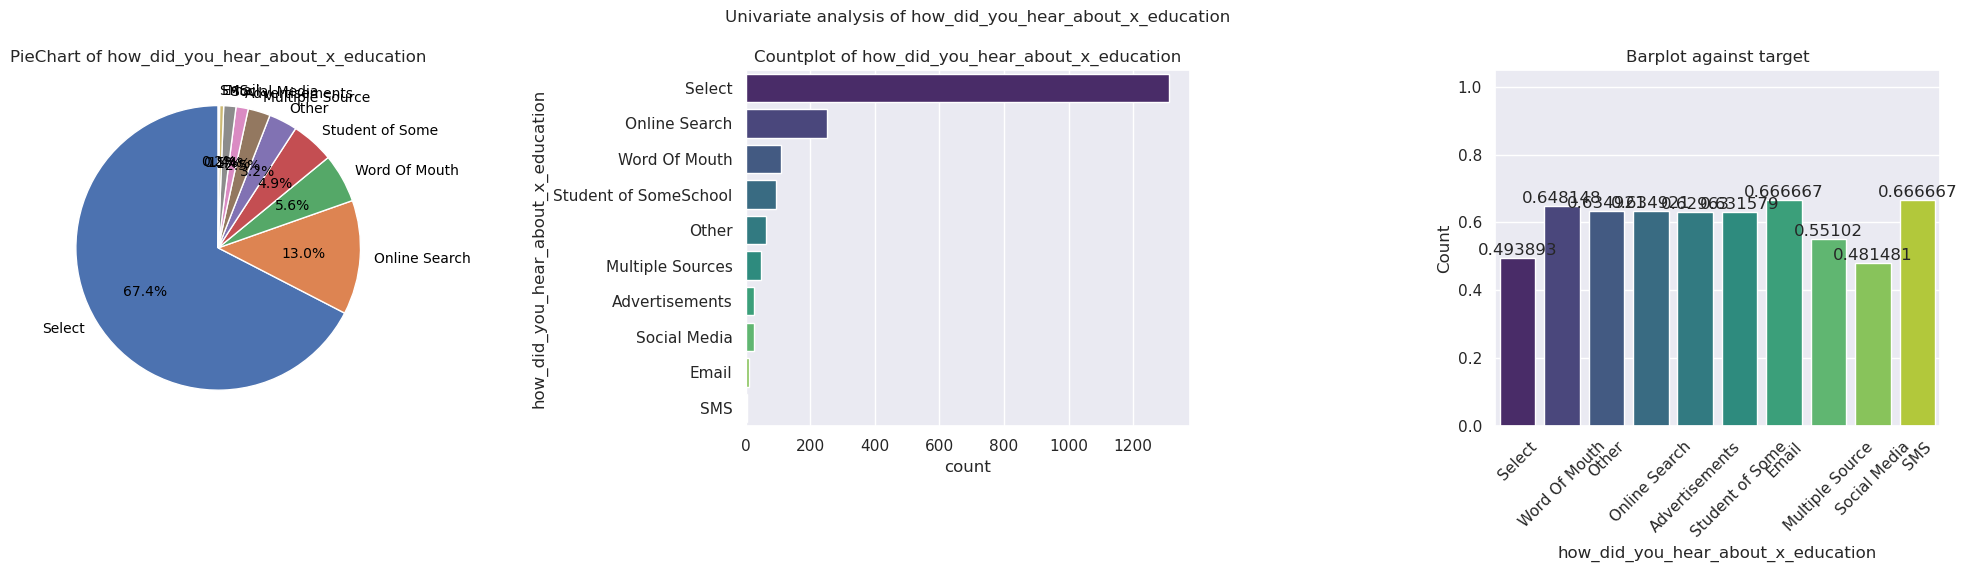

<Figure size 640x480 with 0 Axes>

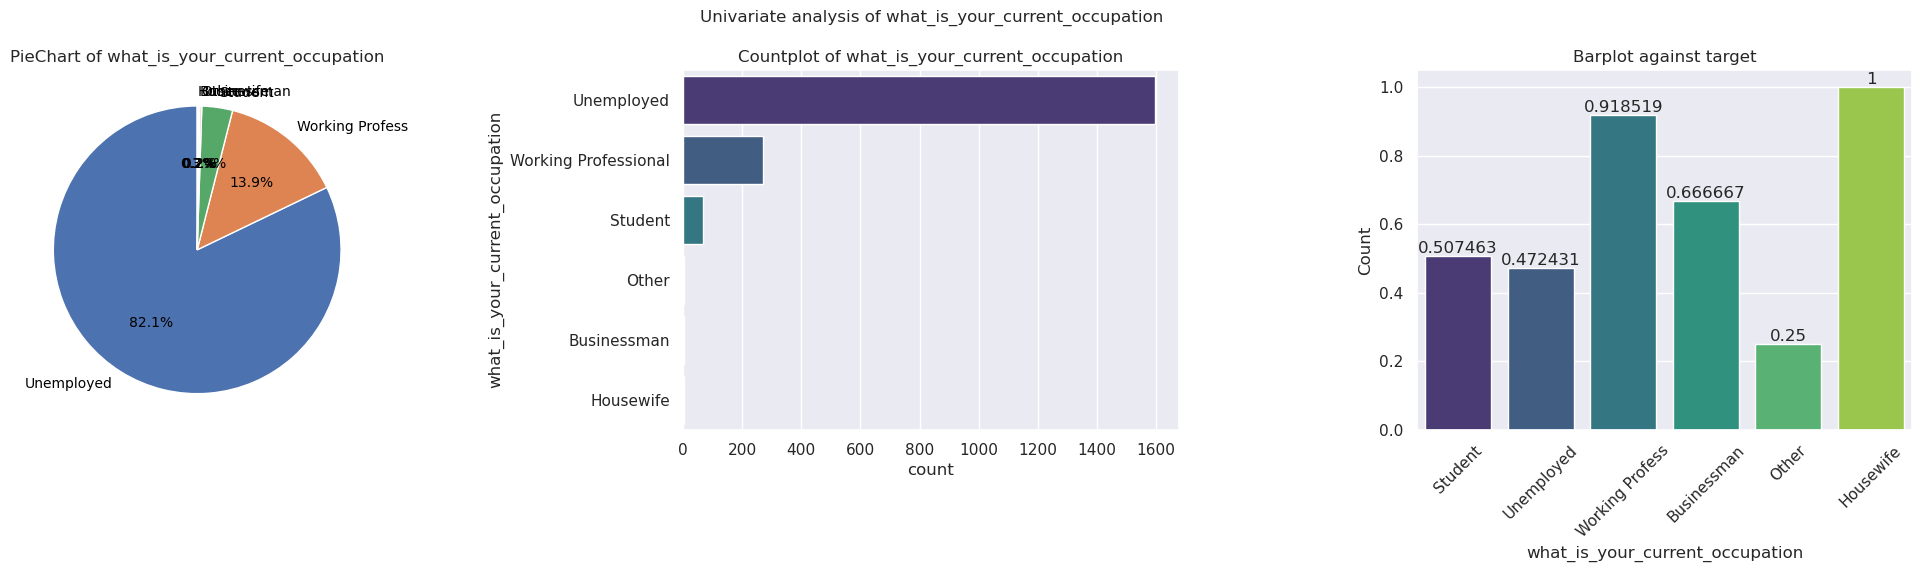

<Figure size 640x480 with 0 Axes>

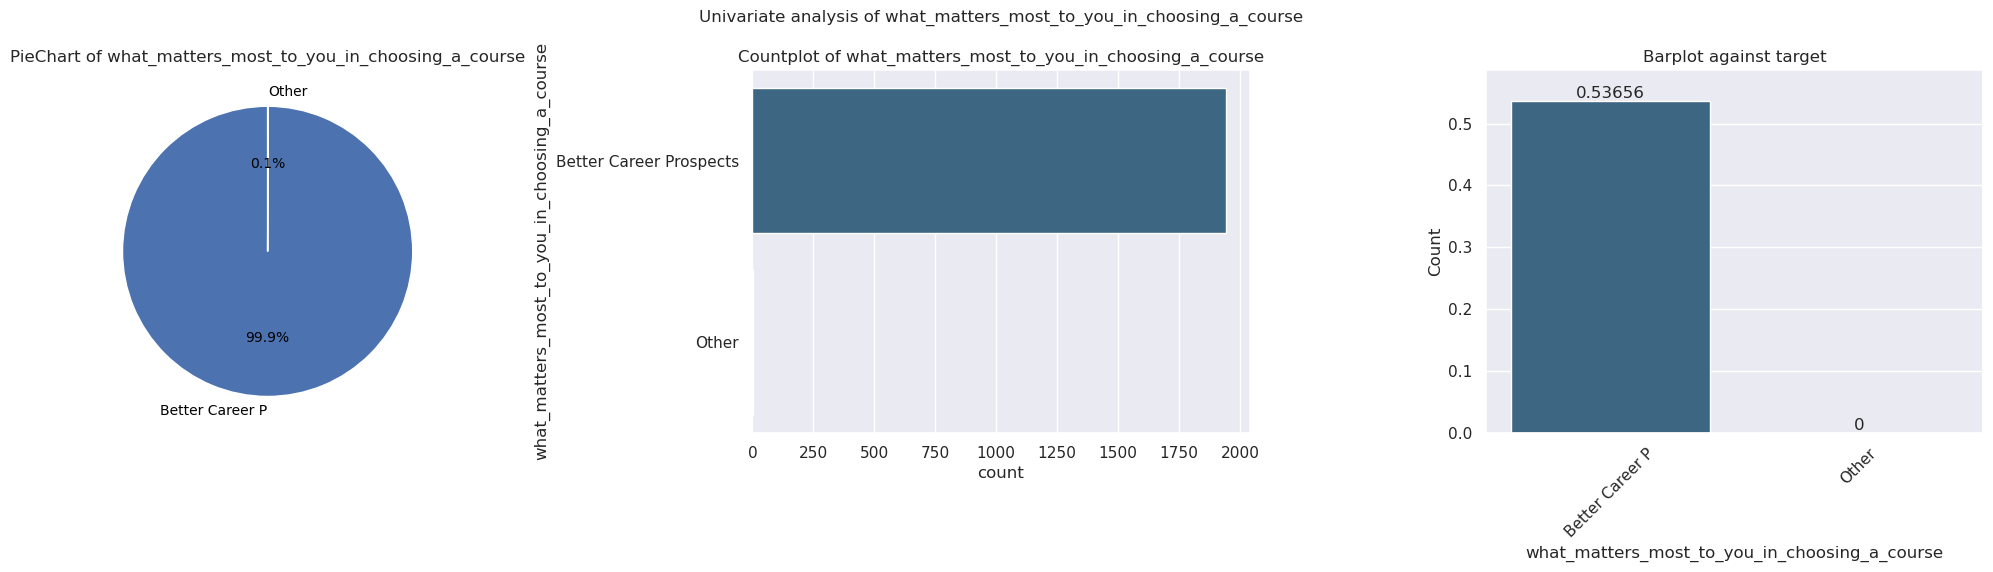

<Figure size 640x480 with 0 Axes>

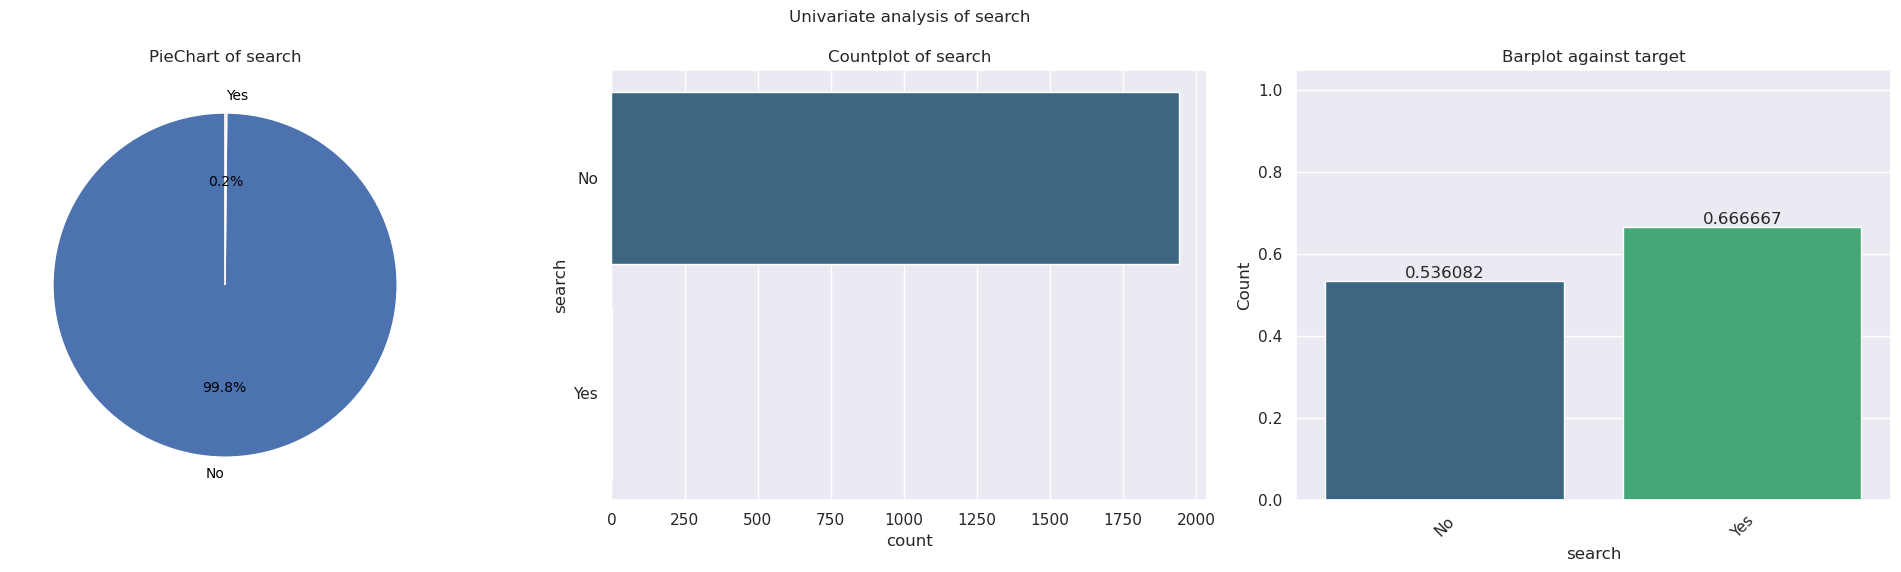

<Figure size 640x480 with 0 Axes>

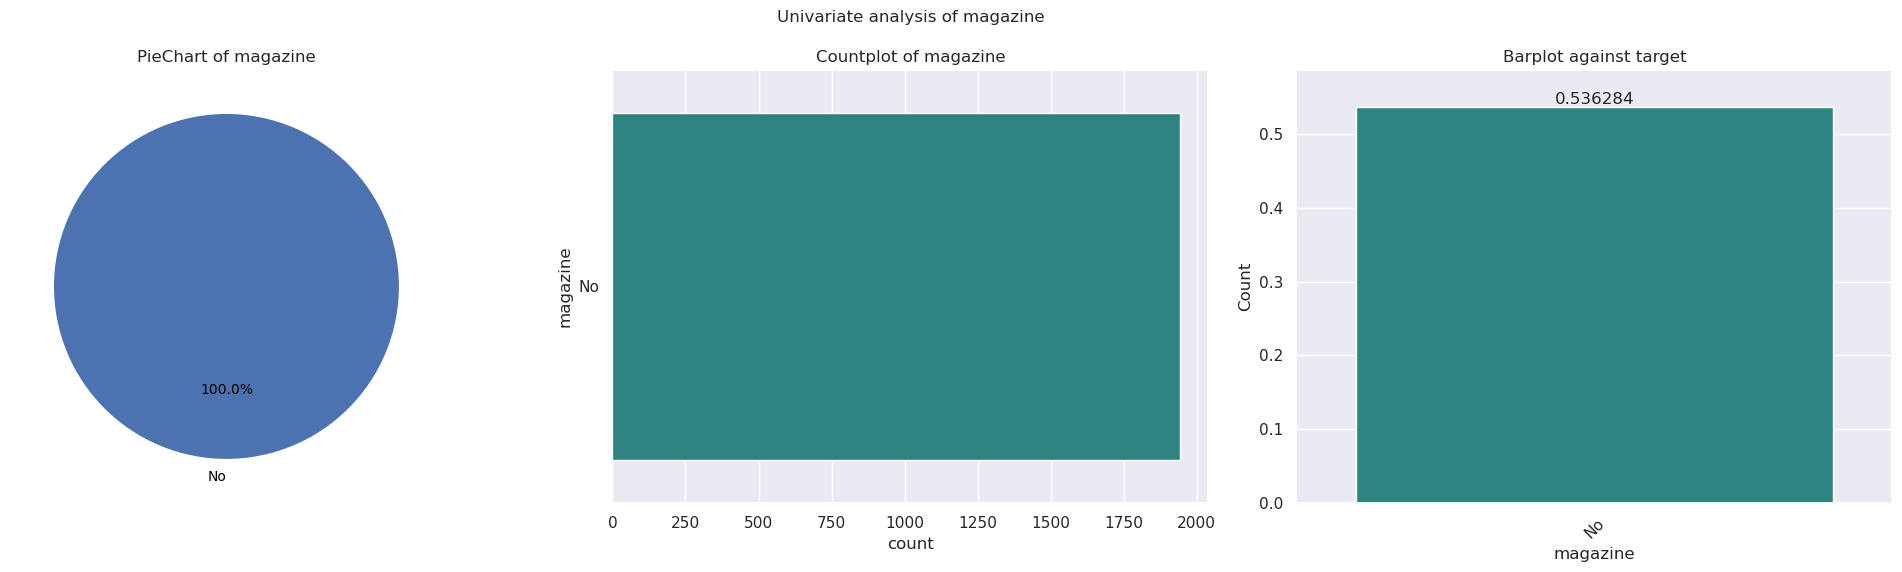

<Figure size 640x480 with 0 Axes>

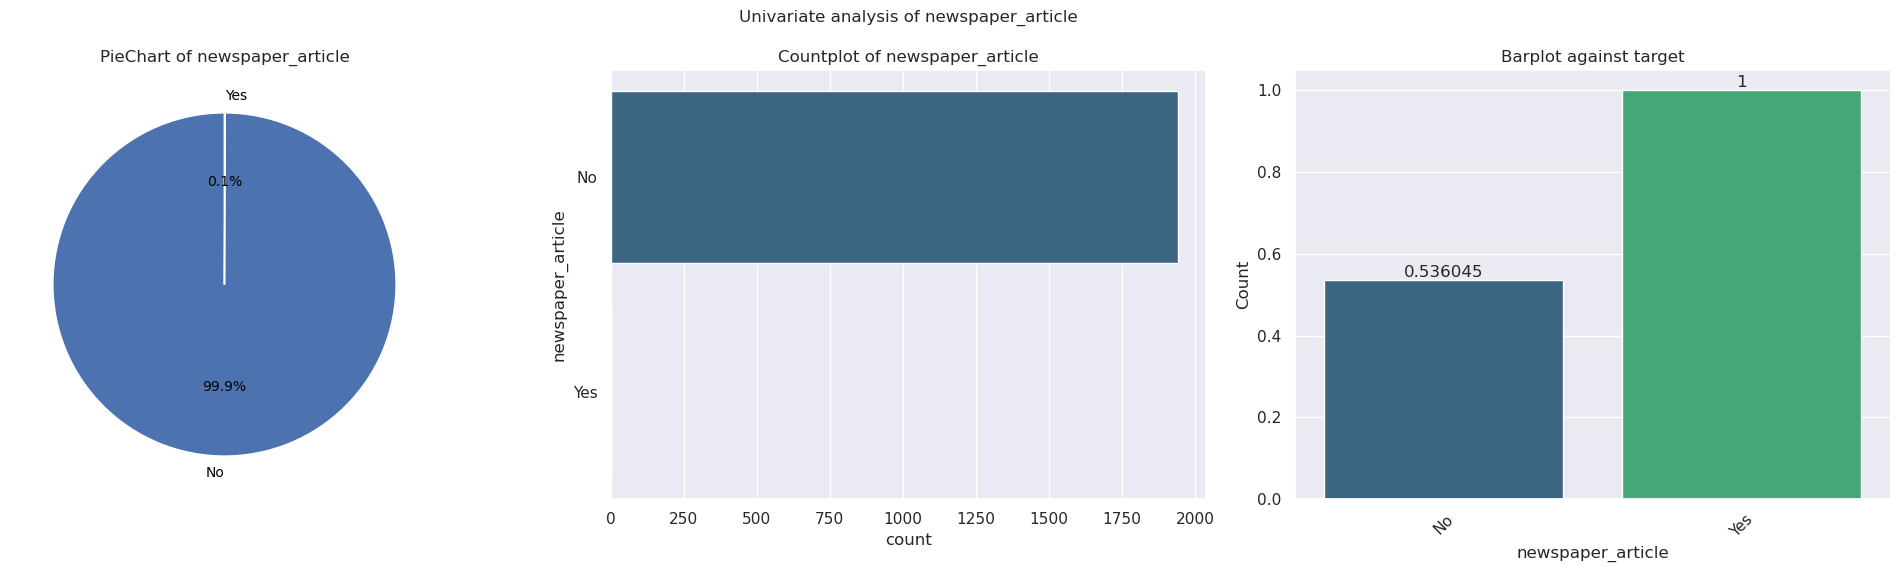

<Figure size 640x480 with 0 Axes>

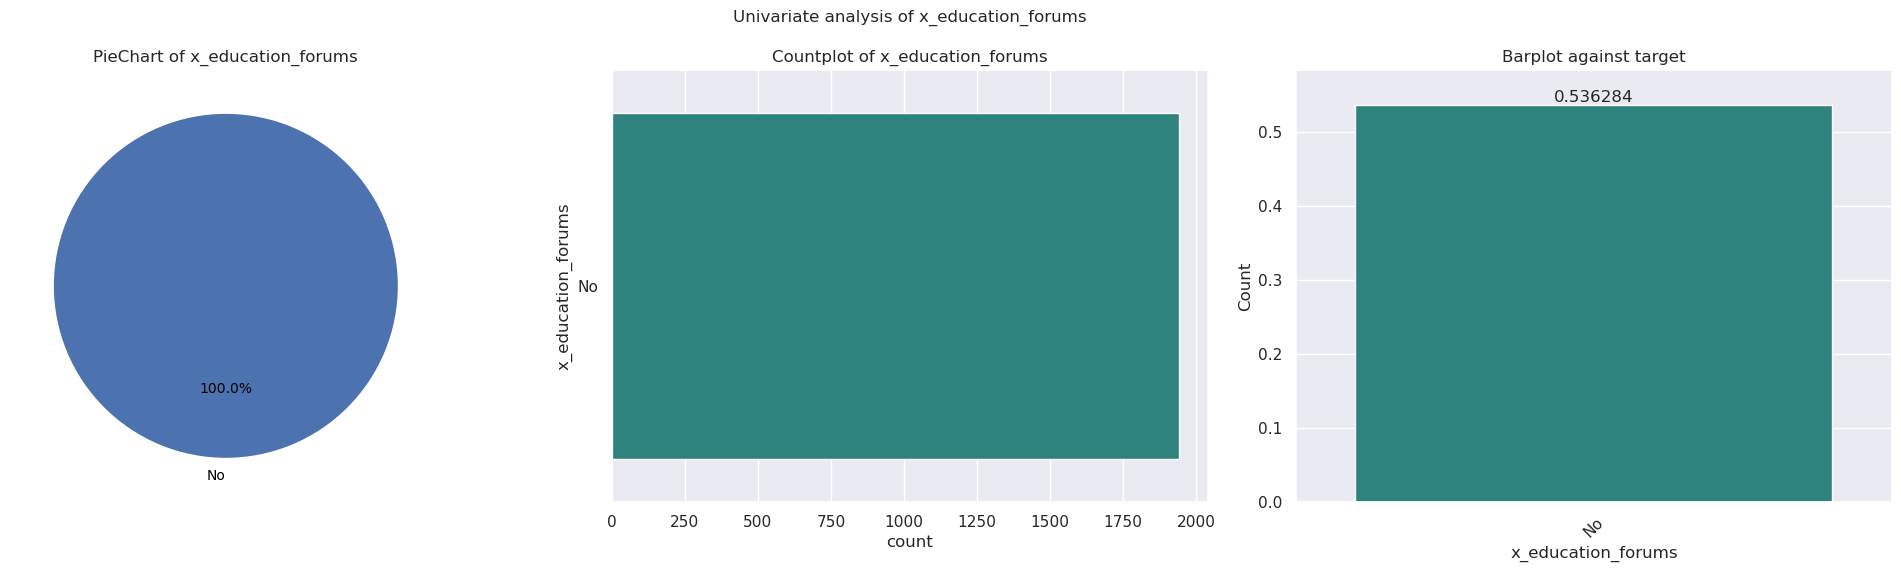

<Figure size 640x480 with 0 Axes>

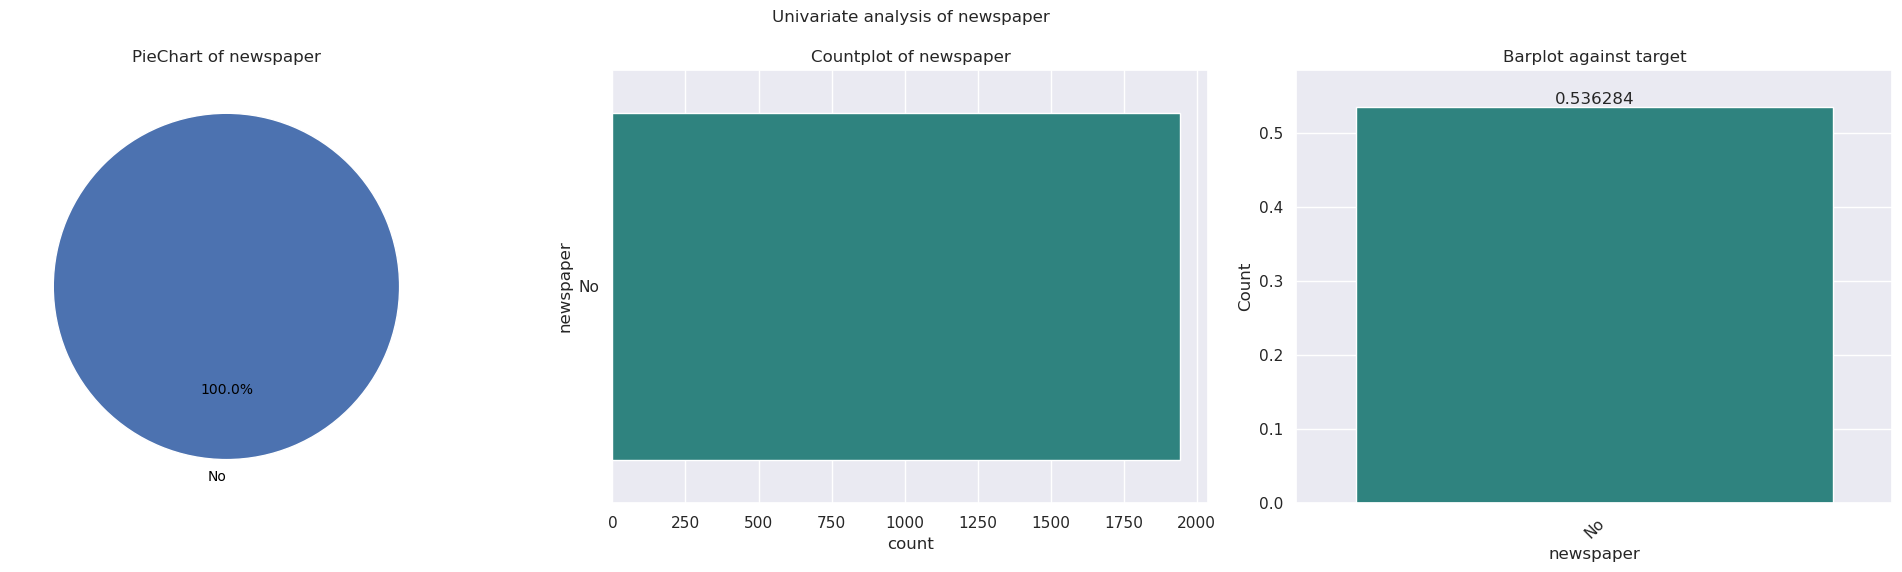

<Figure size 640x480 with 0 Axes>

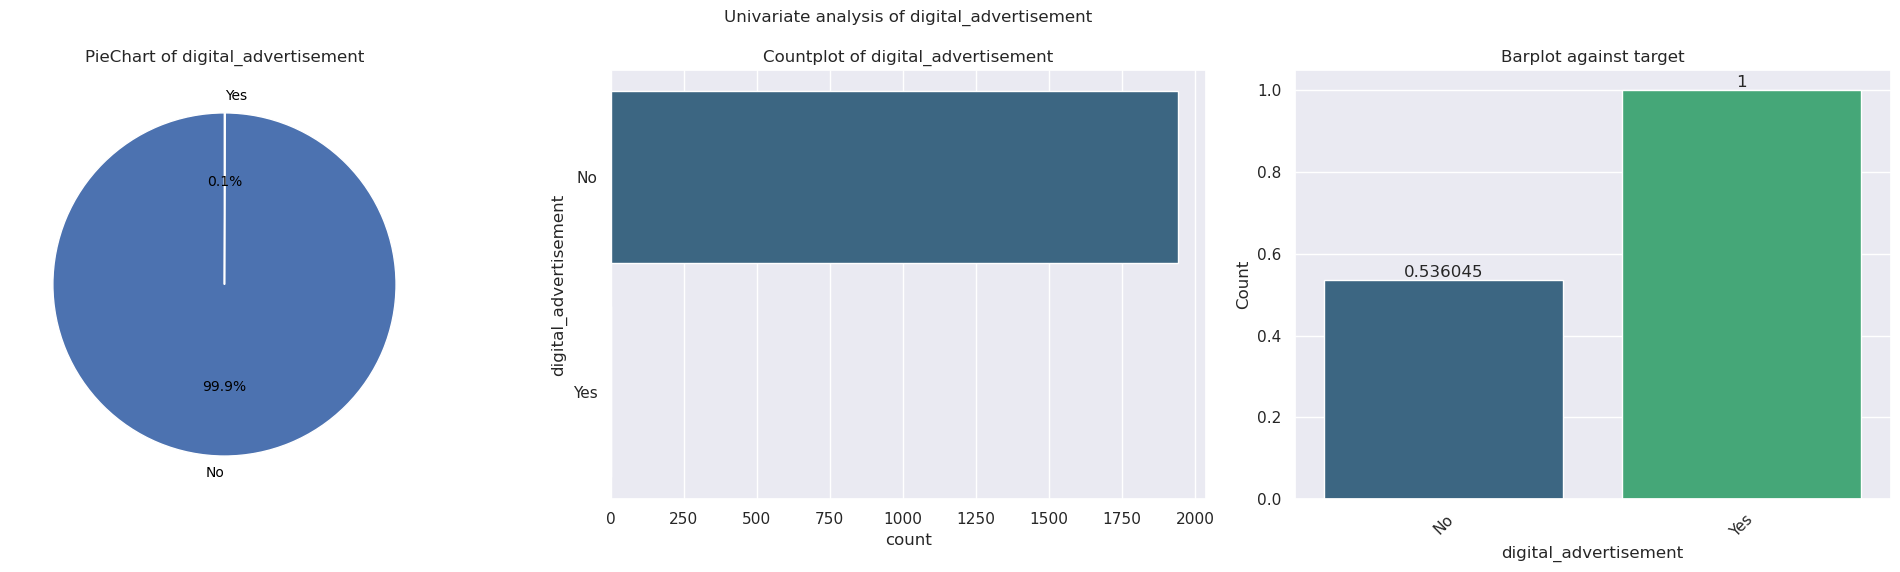

<Figure size 640x480 with 0 Axes>

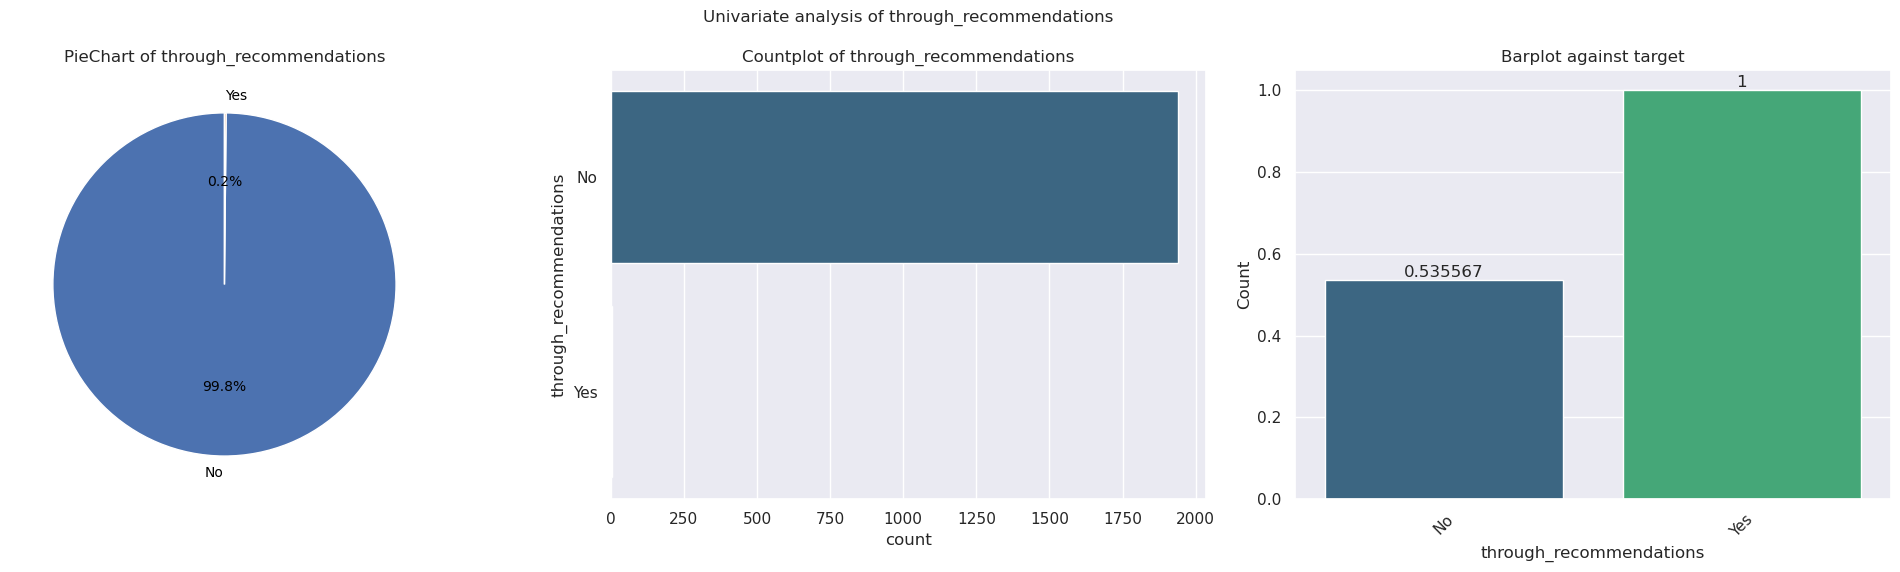

<Figure size 640x480 with 0 Axes>

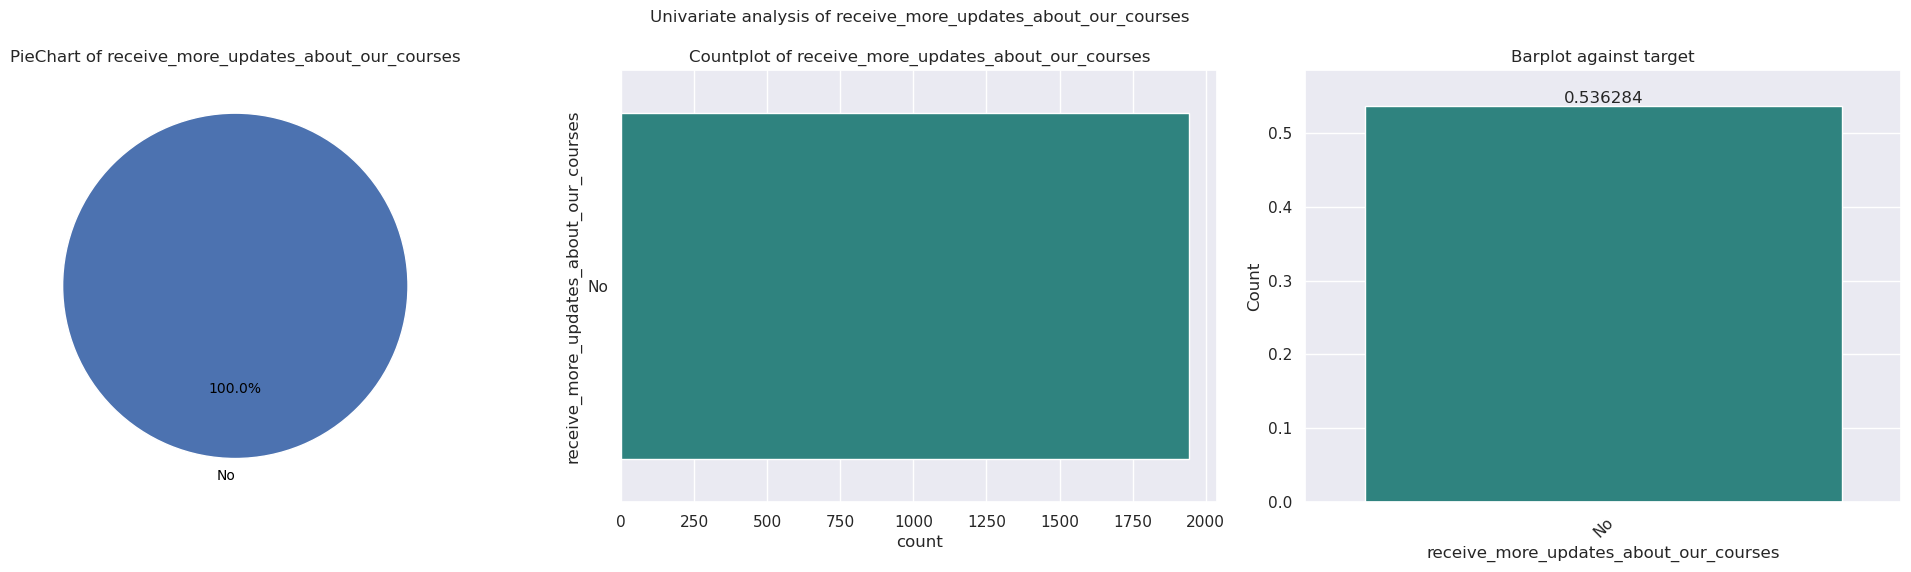

<Figure size 640x480 with 0 Axes>

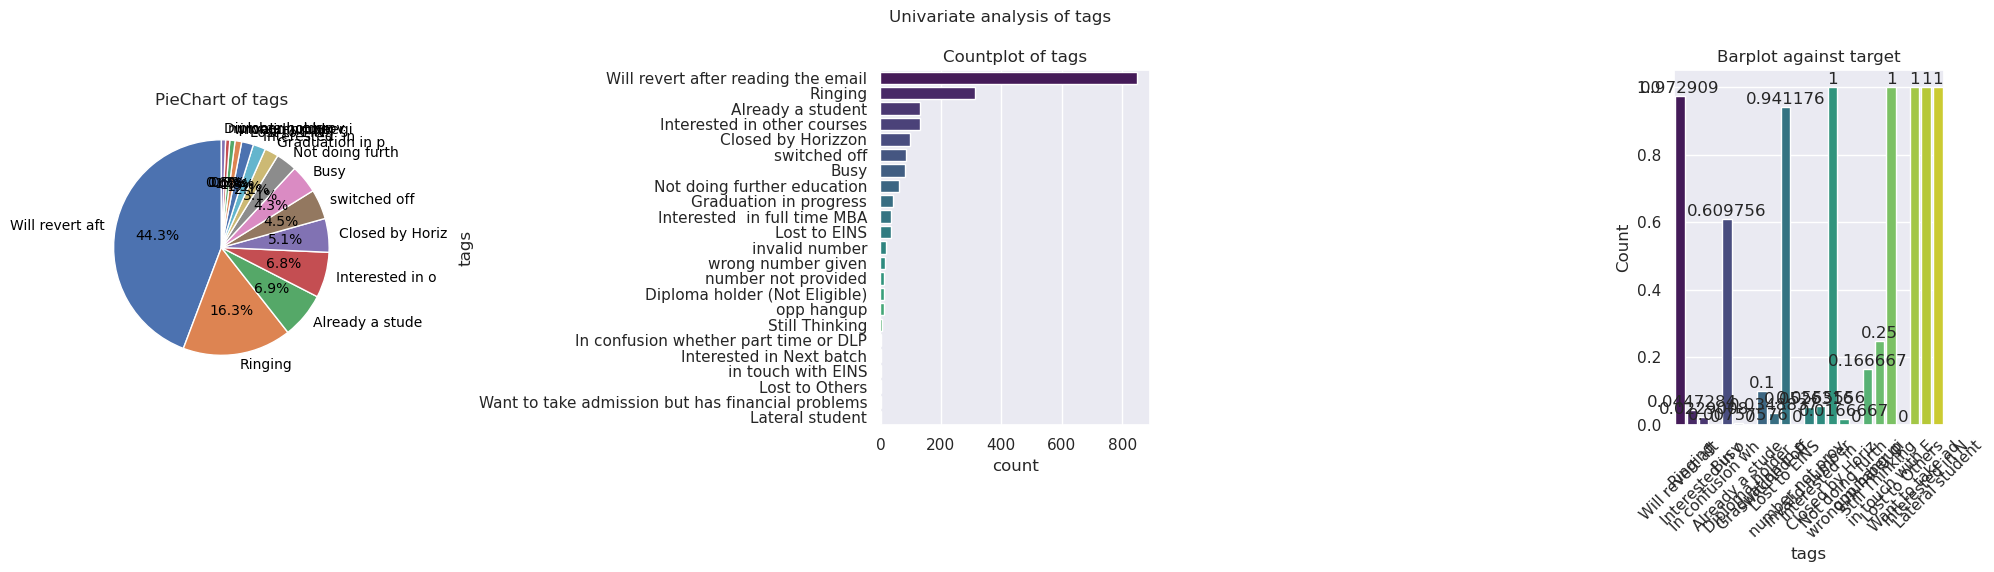

<Figure size 640x480 with 0 Axes>

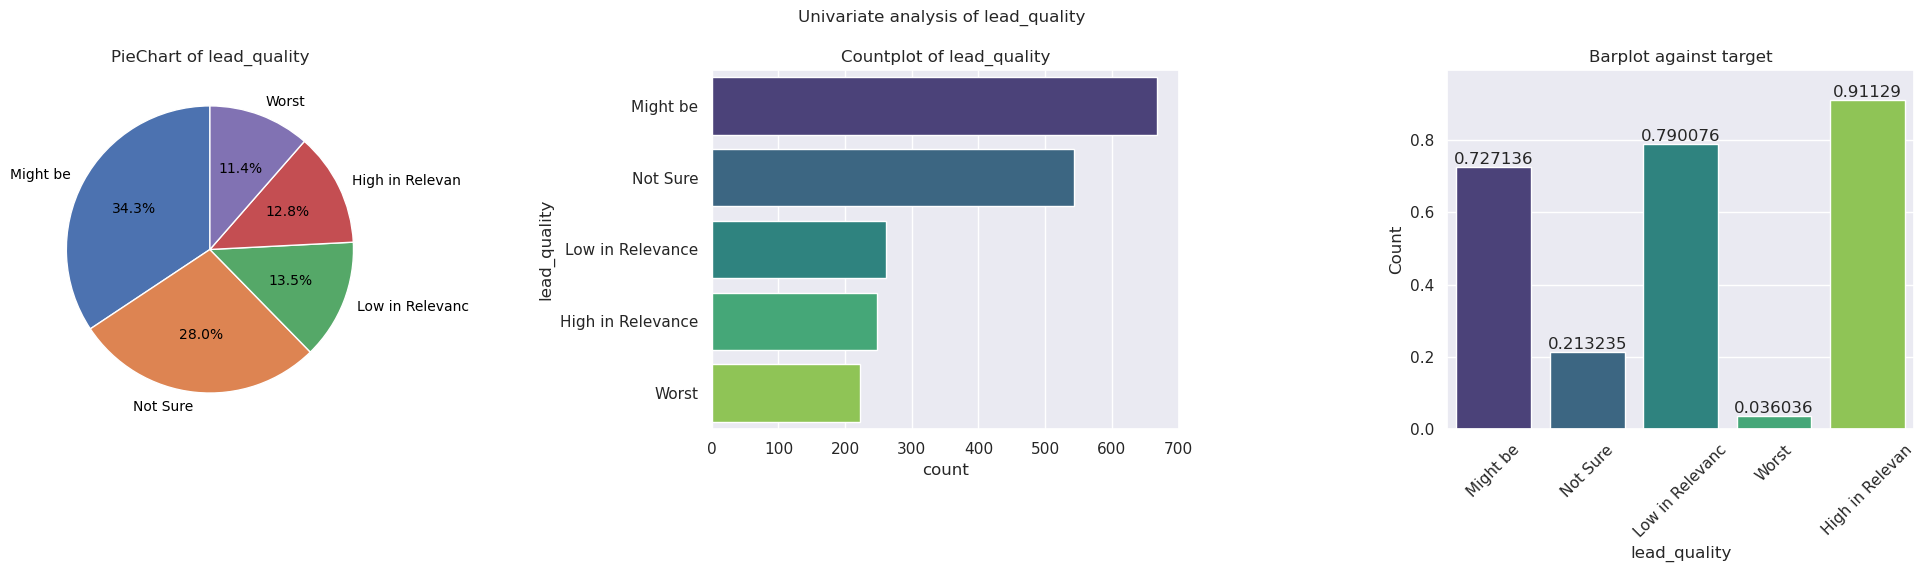

<Figure size 640x480 with 0 Axes>

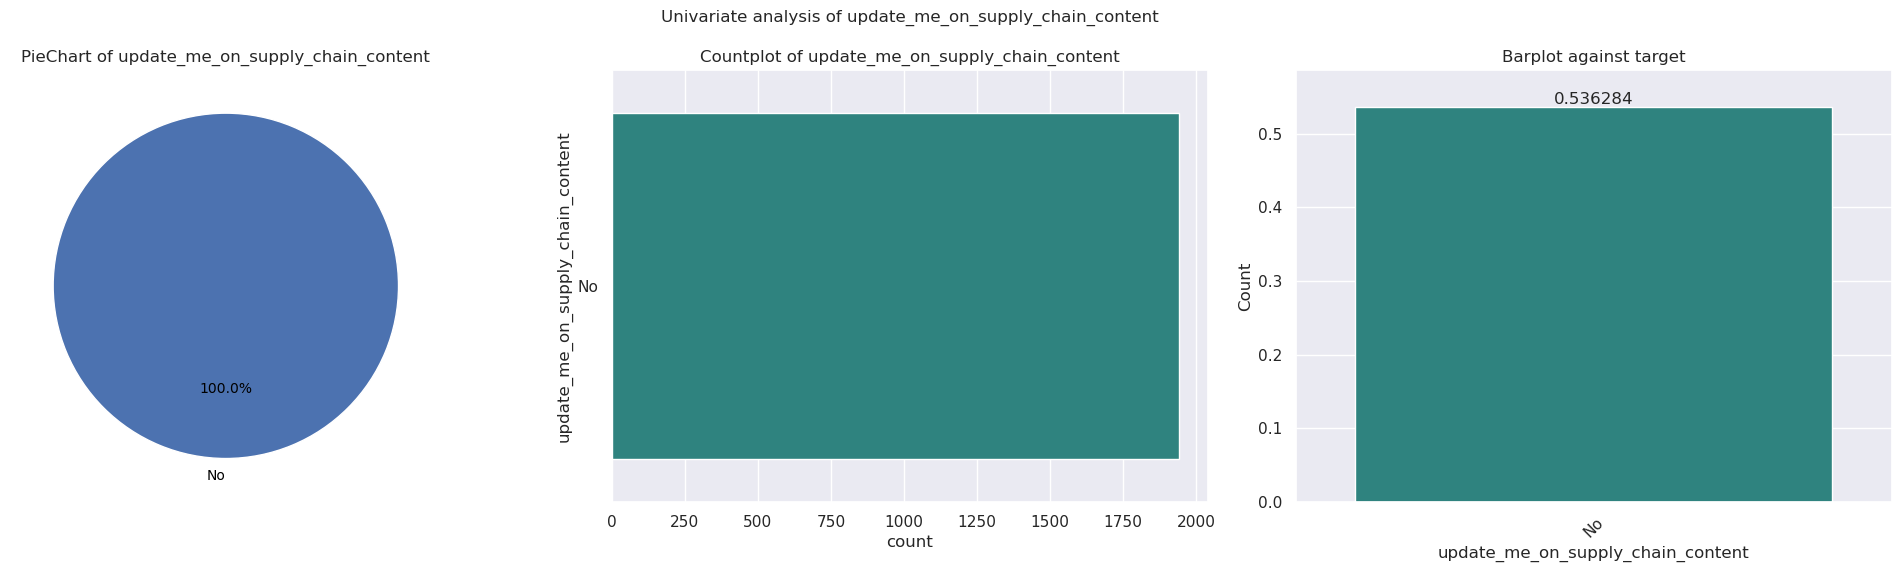

<Figure size 640x480 with 0 Axes>

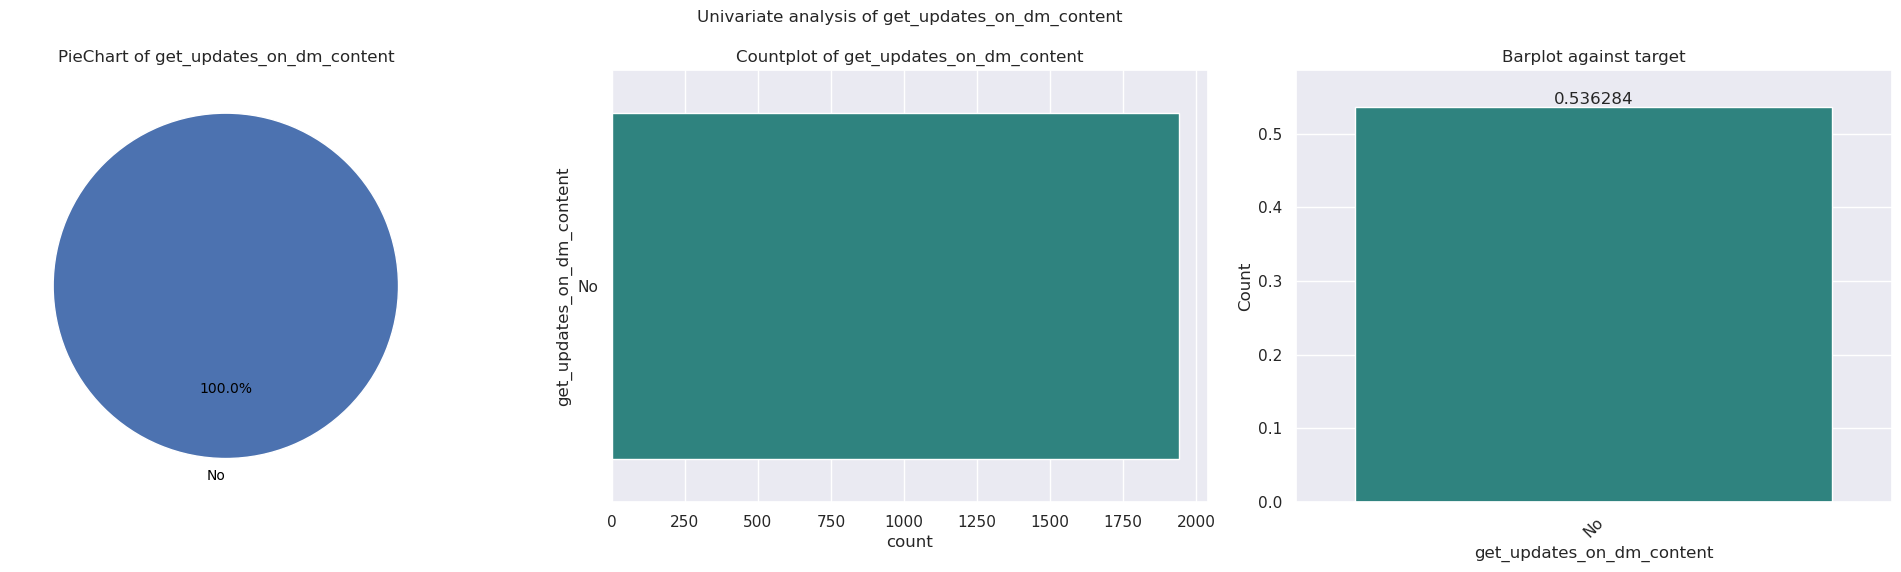

<Figure size 640x480 with 0 Axes>

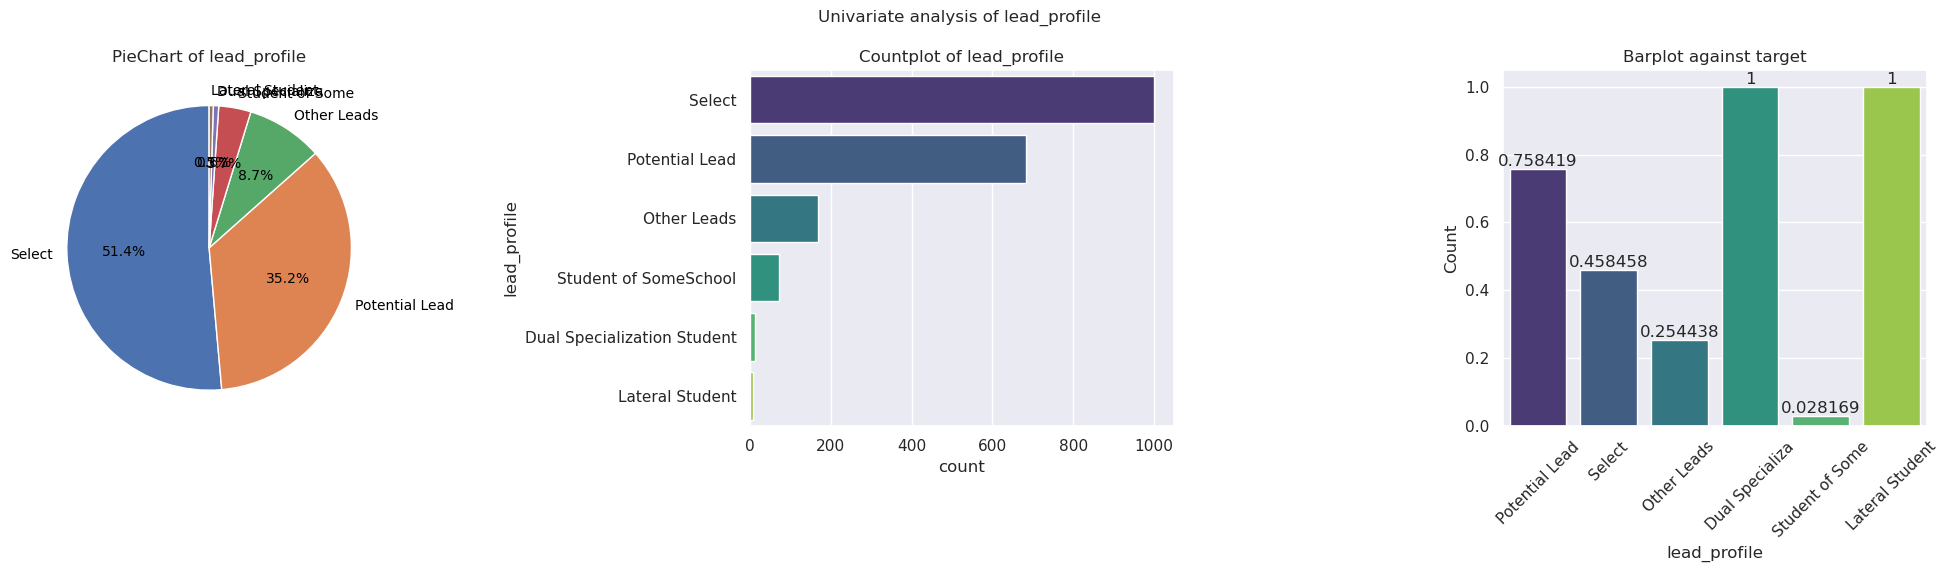

<Figure size 640x480 with 0 Axes>

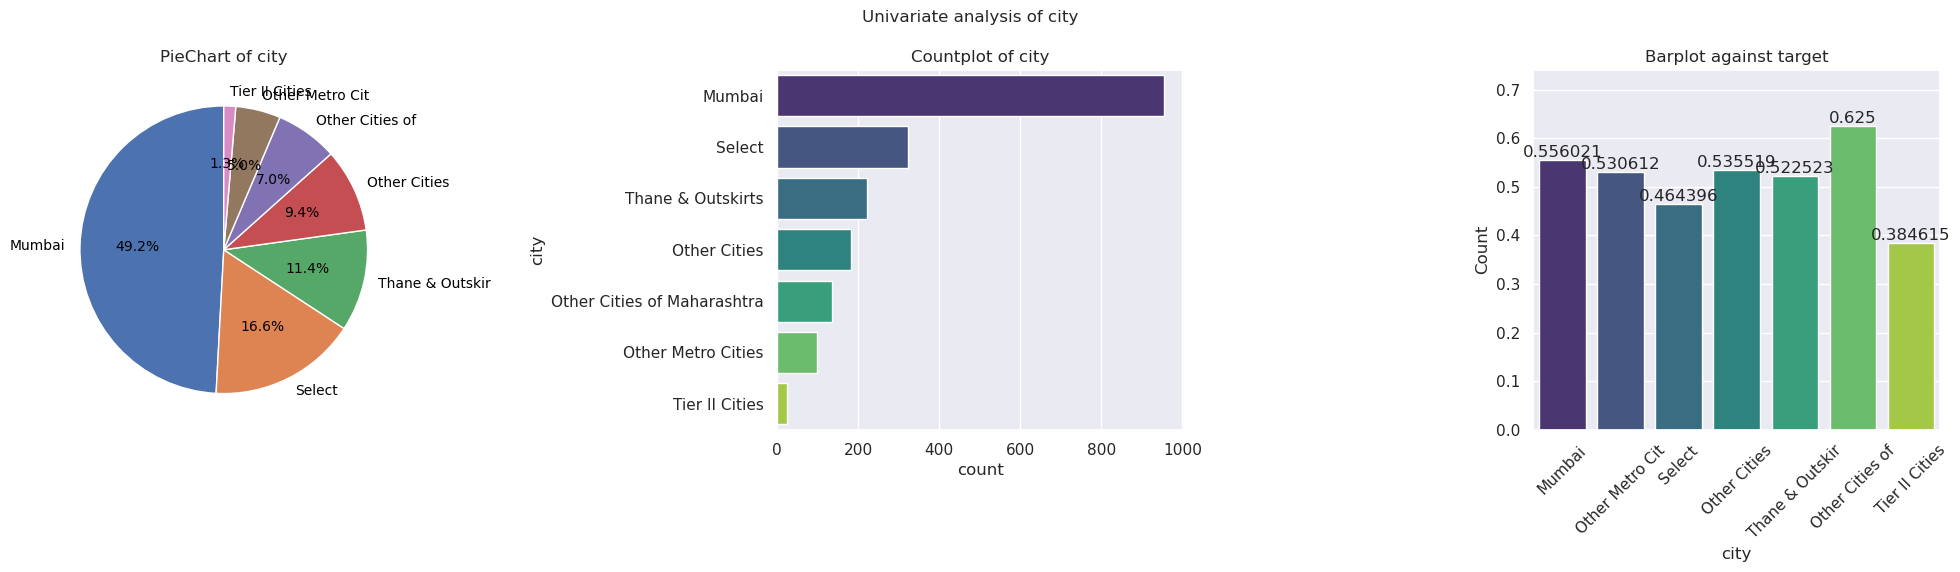

<Figure size 640x480 with 0 Axes>

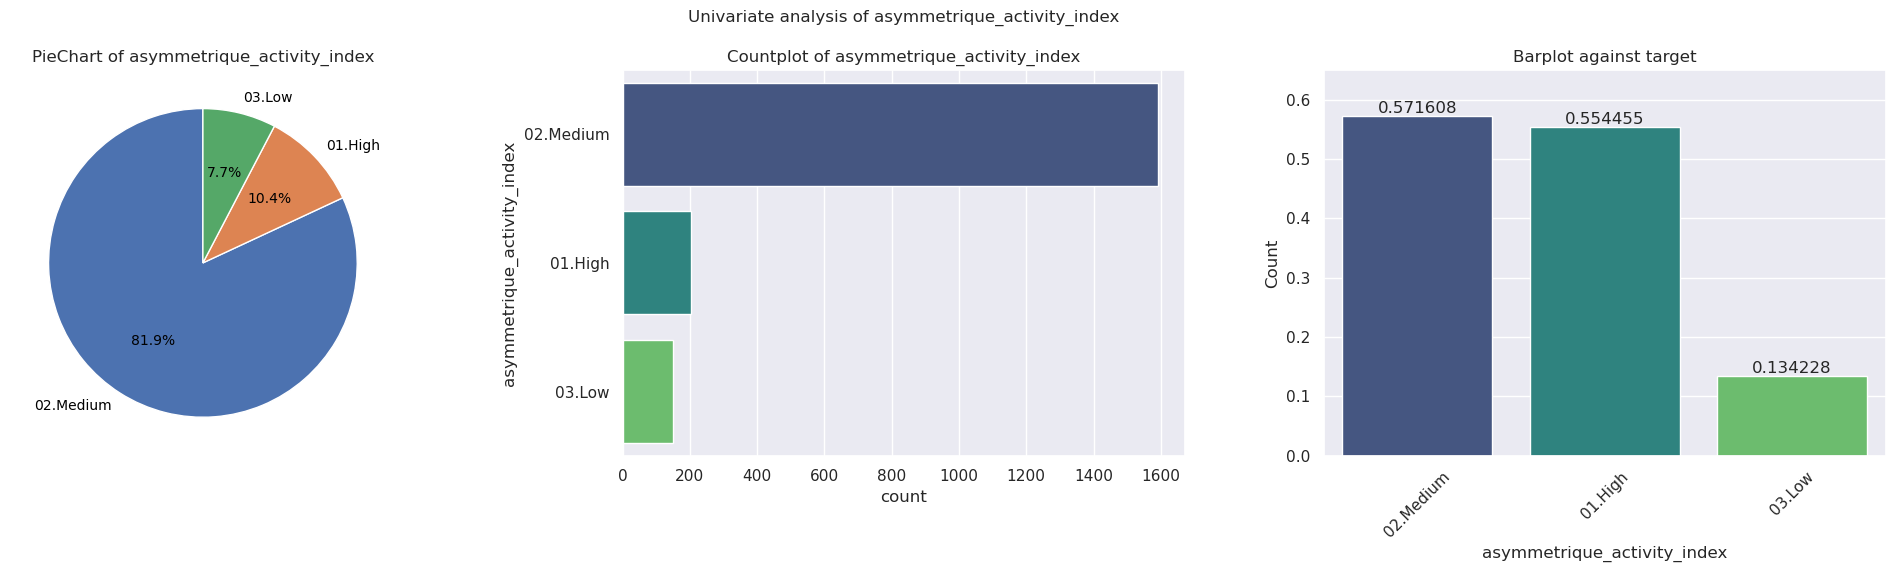

<Figure size 640x480 with 0 Axes>

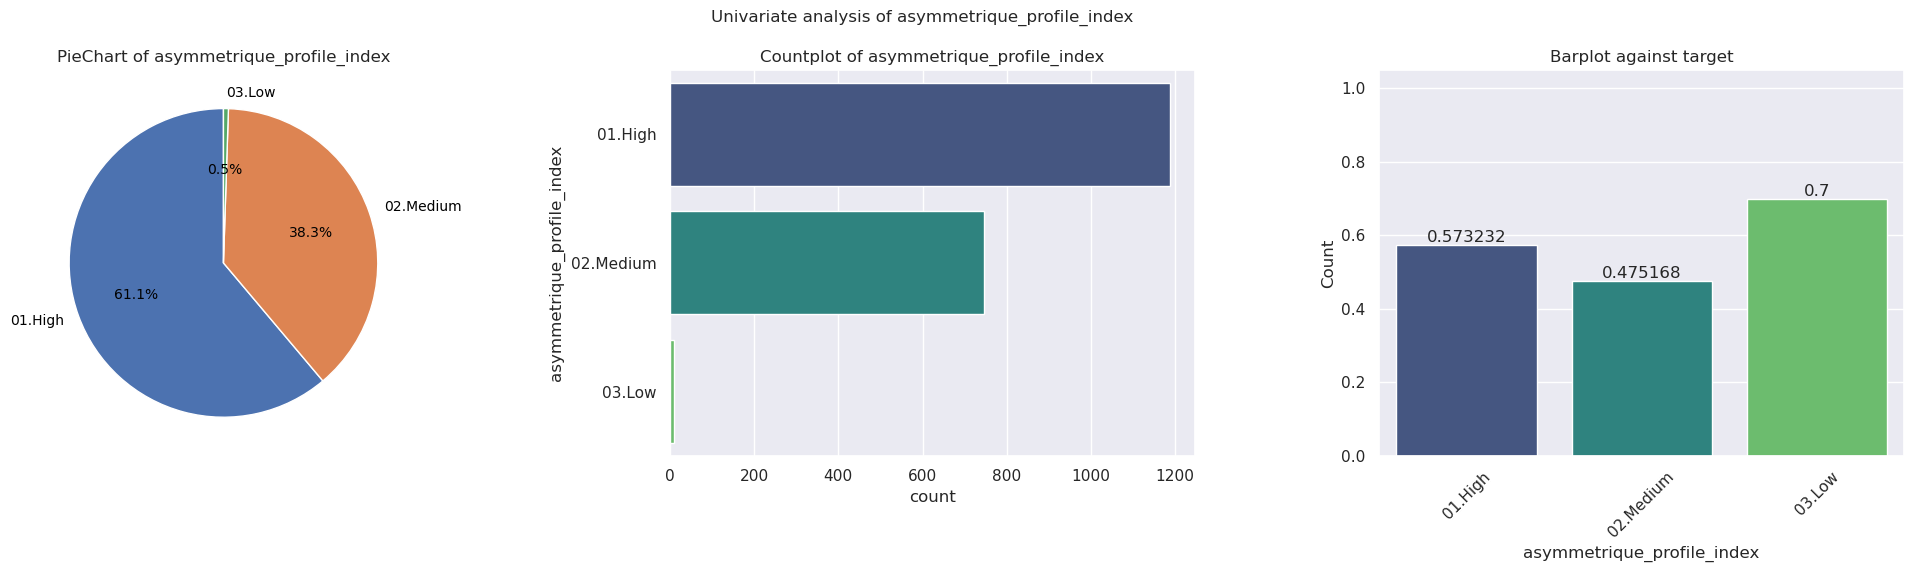

<Figure size 640x480 with 0 Axes>

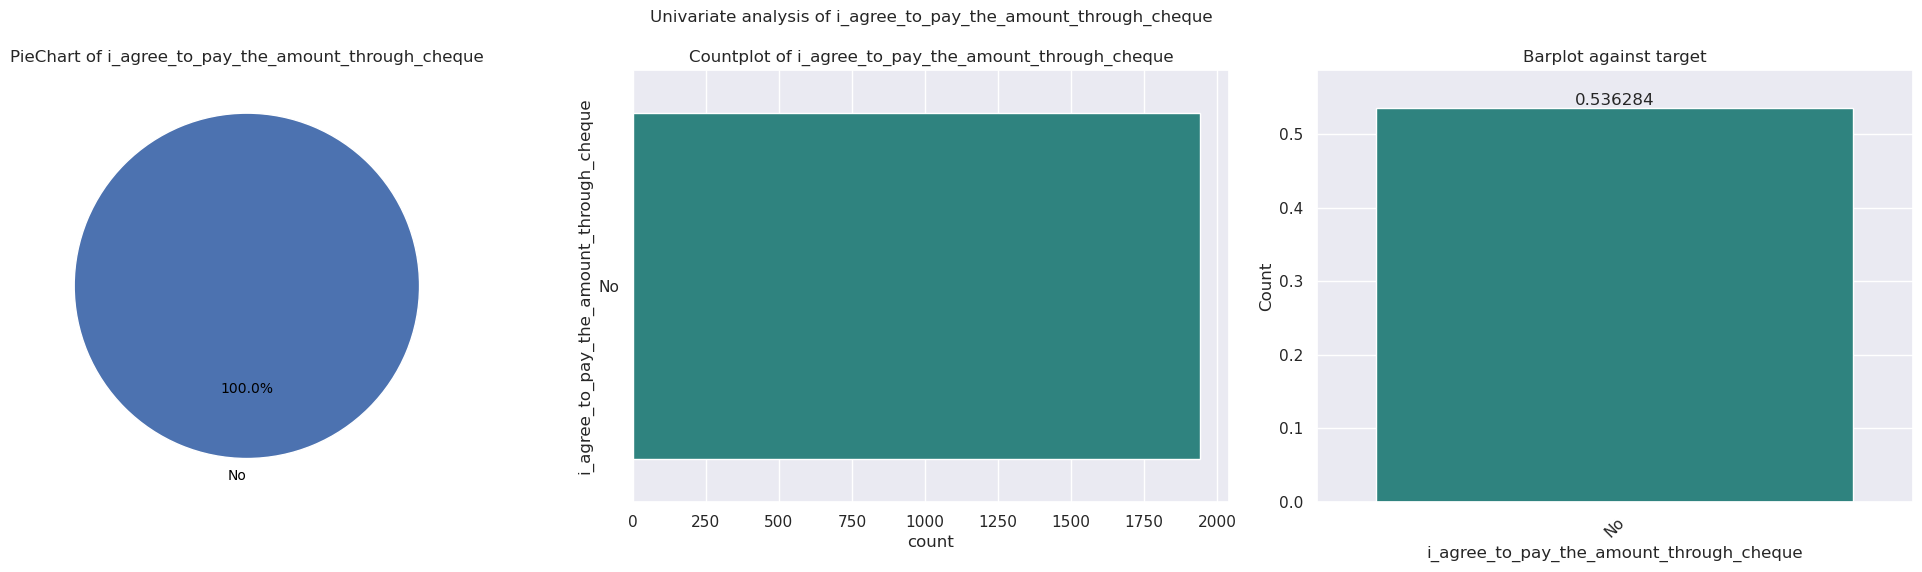

<Figure size 640x480 with 0 Axes>

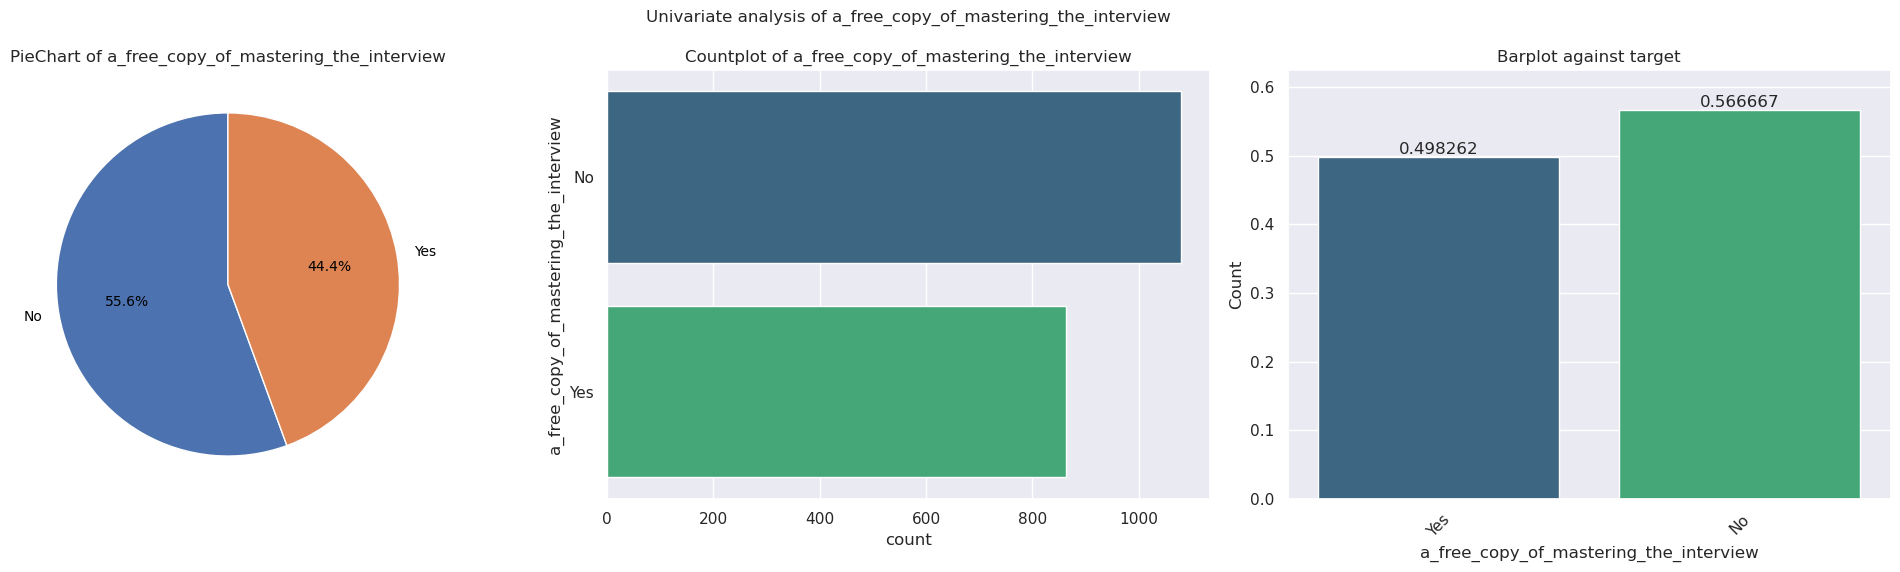

<Figure size 640x480 with 0 Axes>

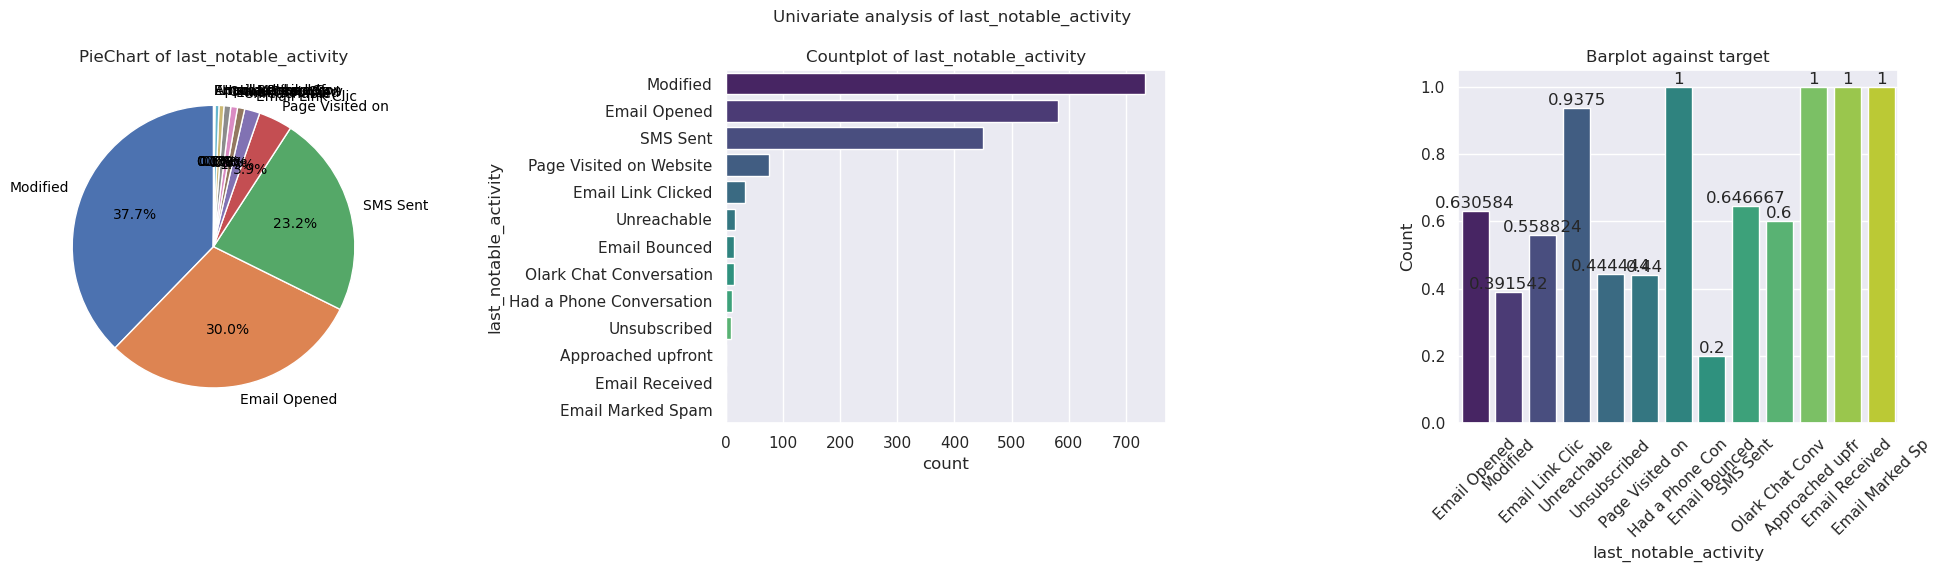

<Figure size 640x480 with 0 Axes>

In [11]:
univariate_plots(dff, dff.select_dtypes(exclude=[int,float]).columns, ftype='categorical',target='converted')

In [12]:
dff.head(2)

prospect_id  lead_number              lead_origin  \
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   

      lead_source do_not_email do_not_call  converted  totalvisits  \
2  Direct Traffic           No          No          1        2.000   
3  Direct Traffic           No          No          0        1.000   

   total_time_spent_on_website  page_views_per_visit last_activity country  \
2                         1532                 2.000  Email Opened   India   
3                          305                 1.000   Unreachable   India   

            specialization how_did_you_hear_about_x_education  \
2  Business Administration                             Select   
3    Media and Advertising                      Word Of Mouth   

  what_is_your_current_occupation  \
2                         Student   
3                      Unemployed   

  what_matters_most_to_you_in_choosing_a_course search magazine  \
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   

  newspaper_article x_education_forums newspaper digital_advertisement  \
2                No                 No        No                    No   
3                No                 No        No                    No   

  through_recommendations receive_more_updates_about_our_courses  \
2                      No                                     No   
3                      No                                     No   

                                  tags lead_quality  \
2  Will revert after reading the email     Might be   
3                              Ringing     Not Sure   

  update_me_on_supply_chain_content get_updates_on_dm_content    lead_profile  \
2                                No                        No  Potential Lead   
3                                No                        No          Select   

     city asymmetrique_activity_index asymmetrique_profile_index  \
2  Mumbai                   02.Medium                    01.High   
3  Mumbai                   02.Medium                    01.High   

   asymmetrique_activity_score  asymmetrique_profile_score  \
2                       14.000                      20.000   
3                       13.000                      17.000   

  i_agree_to_pay_the_amount_through_cheque  \
2                                       No   
3                                       No   

  a_free_copy_of_mastering_the_interview last_notable_activity  
2                                    Yes          Email Opened  
3                                     No              Modified

In [13]:
cols = dff.select_dtypes(exclude=[int,float]).columns
cols = list(set(list(cols)) - set(['prospect_id']))
dff = pd.get_dummies(dff, columns=cols, drop_first=True, dtype=float)

In [14]:
dff.head(2)

prospect_id  lead_number  converted  totalvisits  \
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727          1        2.000   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719          0        1.000   

   total_time_spent_on_website  page_views_per_visit  \
2                         1532                 2.000   
3                          305                 1.000   

   asymmetrique_activity_score  asymmetrique_profile_score  \
2                       14.000                      20.000   
3                       13.000                      17.000   

   last_activity_Converted to Lead  last_activity_Email Bounced  \
2                            0.000                        0.000   
3                            0.000                        0.000   

   last_activity_Email Link Clicked  last_activity_Email Marked Spam  \
2                             0.000                            0.000   
3                             0.000                            0.000   

   last_activity_Email Opened  last_activity_Email Received  \
2                       1.000                         0.000   
3                       0.000                         0.000   

   last_activity_Form Submitted on Website  \
2                                    0.000   
3                                    0.000   

   last_activity_Had a Phone Conversation  \
2                                   0.000   
3                                   0.000   

   last_activity_Olark Chat Conversation  \
2                                  0.000   
3                                  0.000   

   last_activity_Page Visited on Website  last_activity_SMS Sent  \
2                                  0.000                   0.000   
3                                  0.000                   0.000   

   last_activity_Unreachable  last_activity_Unsubscribed  \
2                      0.000                       0.000   
3                      1.000                       0.000   

   last_activity_Visited Booth in Tradeshow  search_Yes  city_Other Cities  \
2                                     0.000       0.000              0.000   
3                                     0.000       0.000              0.000   

   city_Other Cities of Maharashtra  city_Other Metro Cities  city_Select  \
2                             0.000                    0.000        0.000   
3                             0.000                    0.000        0.000   

   city_Thane & Outskirts  city_Tier II Cities  \
2                   0.000                0.000   
3                   0.000                0.000   

   what_is_your_current_occupation_Housewife  \
2                                      0.000   
3                                      0.000   

   what_is_your_current_occupation_Other  \
2                                  0.000   
3                                  0.000   

   what_is_your_current_occupation_Student  \
2                                    1.000   
3                                    0.000   

   what_is_your_current_occupation_Unemployed  \
2                                       0.000   
3                                       1.000   

   what_is_your_current_occupation_Working Professional  tags_Busy  \
2                                              0.000         0.000   
3                                              0.000         0.000   

   tags_Closed by Horizzon  tags_Diploma holder (Not Eligible)  \
2                    0.000                               0.000   
3                    0.000                               0.000   

   tags_Graduation in progress  tags_In confusion whether part time or DLP  \
2                        0.000                                       0.000   
3                        0.000                                       0.000   

   tags_Interested  in full time MBA  tags_Interested in Next batch  \
2                              0.000                          0.000   
3                              0.000                      

In [15]:
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [16]:
X = dff.drop(['prospect_id','converted'],axis=1)
y = dff['converted']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [19]:
to_scale = ['lead_number', 'totalvisits', 'total_time_spent_on_website', 'page_views_per_visit', 'asymmetrique_activity_score','asymmetrique_profile_score']

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale],y_train)
X_train

lead_number  totalvisits  total_time_spent_on_website  \
422         1.239       -0.733                       -0.058   
868         1.083        0.613                        0.178   
3175        0.347        1.959                        0.922   
8270       -1.108       -0.195                       -0.817   
8704       -1.220       -0.733                        1.570   
...           ...          ...                          ...   
9094       -1.314       -0.733                        0.043   
9142       -1.325       -0.464                       -0.907   
9051       -1.302        0.344                        0.136   
2185        0.658       -0.464                       -0.847   
8286       -1.111       -0.464                        1.363   

      page_views_per_visit  asymmetrique_activity_score  \
422                 -0.654                       -0.872   
868                  0.165                       -0.089   
3175                -0.436                        1.477   
8270                 0.439                        0.694   
8704                -0.654                       -0.872   
...                    ...                          ...   
9094                -1.201                        1.477   
9142                -0.108                       -0.089   
9051                -0.108                       -2.438   
2185                -0.108                       -0.872   
8286                -0.108                        0.694   

      asymmetrique_profile_score  last_activity_Converted to Lead  \
422                        0.541                            0.000   
868                        1.071                            0.000   
3175                       0.541                            0.000   
8270                       1.601                            0.000   
8704                       1.601                            0.000   
...                          ...                              ...   
9094                      -1.049                            0.000   
9142                       1.601                            0.000   
9051                       0.541                            0.000   
2185                       0.541                            0.000   
8286                       1.601                            0.000   

      last_activity_Email Bounced  last_activity_Email Link Clicked  \
422                         0.000                             0.000   
868                         0.000                             0.000   
3175                        0.000                             0.000   
8270                        0.000                             0.000   
8704                        0.000                             1.000   
...                           ...                               ...   
9094                        0.000                             0.000   
9142                        0.000                             0.000   
9051                        0.000                             0.000   
2185                        0.000                             0.000   
8286                        0.000                             0.000   

      last_activity_Email Marked Spam  last_activity_Email Opened  \
422                             0.000                       1.000   
868                             0.000                       1.000   
3175                            0.000                       0.000   
8270                            0.000                       1.000   
8704                            0.000                       0.000   
...                               ...                         ...   
9094                            0.000                       0.000   
9142                            0.000                       0.000   
9051                            0.000                       1.000   
2185                            0.000                       1.000   
8286                            0.000                       0.000   

      last_activity_Email Rec

<Figure size 2000x1000 with 0 Axes>

<Axes: >

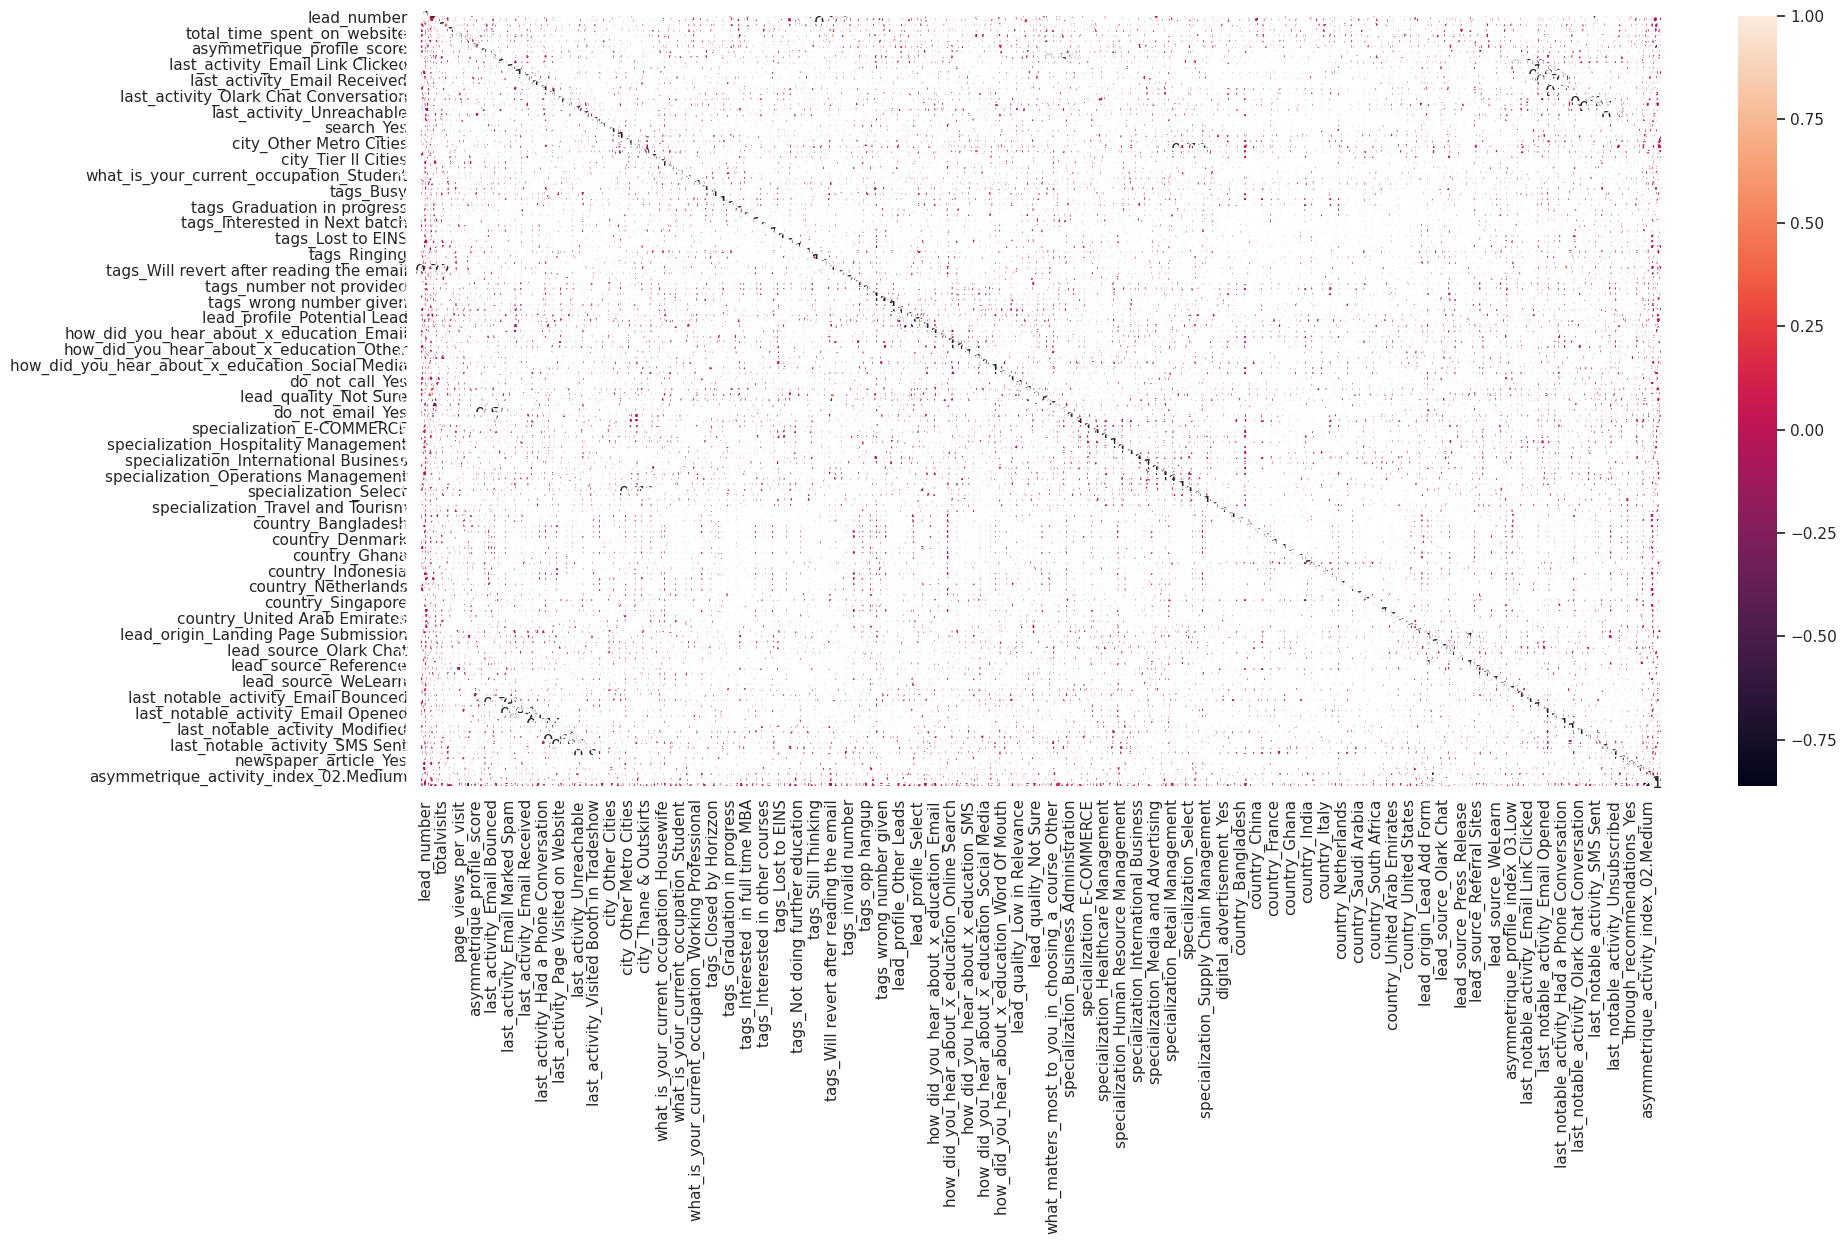

In [20]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(dff.select_dtypes(exclude='object').corr(),annot = True)
plt.show()

In [21]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 1554
Model:                            GLM   Df Residuals:                     1416
Model Family:                Binomial   Df Model:                          137
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 09 Oct 2024   Deviance:                       5342.0
Time:                        20:43:27   Pearson chi2:                 2.61e+17
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
const                                                     8.095e+15    1.1e+08   7.38e+07      0.000     8.1e+15     8.1e+15
lead_number                                               2.232e+14   2.09e+06   1.07e+08      0.000    2.23e+14    2.23e+14
totalvisits                                               -7.63e+11   2.25e+06  -3.38e+05      0.000   -7.63e+11   -7.63e+11
total_time_spent_on_website                               1.756e+14   2.02e+06   8.69e+07      0.000    1.76e+14    1.76e+14
page_views_per_visit                                     -7.801e+13   2.16e+06  -3.62e+07      0.000    -7.8e+13    -7.8e+13
asymmetrique_activity_score                               3.562e+14   3.73e+06   9.56e+07      0.000    3.56e+14    3.56e+14
asymmetrique_profile_score                               -4.735e+14   1.06e+07  -4.48e+07      0.000   -4.74e+14   -4.74e+14
last_activity_Converted to Lead                          -1.299e+14   4.95e+07  -2.63e+06      0.000    -1.3e+14    -1.3e+14
last_activity_Email Bounced                              -2.803e+15   5.13e+07  -5.47e+07      0.000    -2.8e+15    -2.8e+15
last_activity_Email Link Clicked                         -2.115e+14   5.12e+07  -4.13e+06      0.000   -2.11e+14   -2.11e+14
last_activity_Email Marked Spam                            124.8581   5.95e-06    2.1e+07      0.000     124.858     124.858
last_activity_Email Opened                               -3.448e+14   4.92e+07  -7.01e+06      0.000   -3.45e+14   -3.45e+14
last_activity_Email Received                              3.888e+15   8.47e+07   4.59e+07      0.000    3.89e+15    3.89e+15
last_activity_Form Submitted on Website                   5.627e+14   5.09e+07   1.11e+07      0.000    5.63e+14    5.63e+14
last_activity_Had a Phone Conversation                   -5.535e+14   5.46e+07  -1.01e+07      0.000   -5.54e+14   -5.54e+14
last_activity_Olark Chat Conversation                      1.07e+14   4.99e+07   2.15e+06      0.000    1.07e+14    1.07e+14
last_activity_Page Visited on Website                     -3.33e+14   4.95e+07  -6.73e+06      0.000   -3.33e+14   -3.33e+14
last_activity_SMS Sent                                    2.479e+14   4.94e+07   5.02e+06      0.000    2.48e+14    2.48e+14
last_activity_Unreachable                                 6.065e+13   5.09e+07   1.19e+06      0.000    6.07e+13    6.07e+13
last_activity_Unsubscribed                                9.558e+14   6.05e+07   1.58e+07      0.000    9.56e+14    9.56e+14
last_activity_Visited Booth in Tradeshow                 -2.183e+15   8.65e+07  -2.52e+07      0.000   -2.18e+15   -2.18e+15
search_Yes                                               -6.493e+14   5.67e+07  -1.

In [22]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [23]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 13 variables as output
rfe = rfe.fit(X_train, y_train)

In [24]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('lead_number', False, 19),
 ('totalvisits', False, 72),
 ('total_time_spent_on_website', False, 2),
 ('page_views_per_visit', False, 53),
 ('asymmetrique_activity_score', True, 1),
 ('asymmetrique_profile_score', False, 95),
 ('last_activity_Converted to Lead', False, 88),
 ('last_activity_Email Bounced', True, 1),
 ('last_activity_Email Link Clicked', False, 111),
 ('last_activity_Email Marked Spam', False, 125),
 ('last_activity_Email Opened', False, 110),
 ('last_activity_Email Received', False, 94),
 ('last_activity_Form Submitted on Website', False, 7),
 ('last_activity_Had a Phone Conversation', False, 65),
 ('last_activity_Olark Chat Conversation', False, 75),
 ('last_activity_Page Visited on Website', True, 1),
 ('last_activity_SMS Sent', False, 18),
 ('last_activity_Unreachable', False, 47),
 ('last_activity_Unsubscribed', False, 54),
 ('last_activity_Visited Booth in Tradeshow', False, 114),
 ('search_Yes', False, 103),
 ('city_Other Cities', False, 96),
 ('city_Other Citie

In [25]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['lead_number', 'totalvisits', 'total_time_spent_on_website',
       'page_views_per_visit', 'asymmetrique_profile_score',
       'last_activity_Converted to Lead', 'last_activity_Email Link Clicked',
       'last_activity_Email Marked Spam', 'last_activity_Email Opened',
       'last_activity_Email Received',
       ...
       'last_notable_activity_Email Received',
       'last_notable_activity_Modified',
       'last_notable_activity_Olark Chat Conversation',
       'last_notable_activity_Page Visited on Website',
       'last_notable_activity_SMS Sent', 'last_notable_activity_Unreachable',
       'last_notable_activity_Unsubscribed', 'newspaper_article_Yes',
       'through_recommendations_Yes',
       'a_free_copy_of_mastering_the_interview_Yes'],
      dtype='object', length=130)

In [26]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 1554
Model:                            GLM   Df Residuals:                     1538
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -213.28
Date:                Wed, 09 Oct 2024   Deviance:                       426.56
Time:                        20:43:29   Pearson chi2:                 1.42e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.6693
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -4.4492      0.662     -6.722      0.000      -5.746      -3.152
asymmetrique_activity_score                        1.8367      0.280      6.569      0.000       1.289       2.385
last_activity_Email Bounced                       -1.6943      1.081     -1.568      0.117      -3.812       0.424
last_activity_Page Visited on Website             -2.2967      0.515     -4.463      0.000      -3.305      -1.288
city_Other Cities of Maharashtra                   1.4965      0.491      3.049      0.002       0.535       2.458
tags_Busy                                          2.9645      0.466      6.367      0.000       2.052       3.877
tags_Closed by Horizzon                           27.6556   1.29e+04      0.002      0.998   -2.53e+04    2.53e+04
tags_Interested in other courses                  -0.7884      0.697     -1.132      0.258      -2.154       0.577
tags_Lost to EINS                                  7.2895      1.100      6.624      0.000       5.133       9.446
tags_Ringing                                      -0.3604      0.470     -0.767      0.443      -1.281       0.560
tags_Will revert after reading the email           6.2084      0.456     13.617      0.000       5.315       7.102
tags_switched off                                 -0.4453      0.706     -0.631      0.528      -1.829       0.938
lead_quality_Worst                                -2.0493      0.642     -3.194      0.001      -3.307      -0.792
last_notable_activity_Had a Phone Conversation    24.3915   3.35e+04      0.001      0.999   -6.56e+04    6.56e+04
asymmetrique_activity_index_02.Medium              2.0686      0.603      3.428      0.001       0.886       3.251
asymmetrique_activity_index_03.Low                 3.8588      1.185      3.257      0.001       1.537       6.181
==================================================================================================================
"""

In [27]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

422    0.013
868    0.975
3175   0.101
8270   0.994
8704   1.000
7473   0.013
8164   0.975
2054   0.023
2335   0.005
3093   0.005
dtype: float64

In [28]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.0128307 , 0.9750108 , 0.10137048, 0.99395297, 1.        ,
       0.0128307 , 0.9750108 , 0.02267704, 0.00547767, 0.00547767])

In [29]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

Churn  Churn_Prob  CustID
0      1       0.013     422
1      1       0.975     868
2      1       0.101    3175
3      1       0.994    8270
4      1       1.000    8704

In [30]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

Churn  Churn_Prob  CustID  predicted
0      1       0.013     422          0
1      1       0.975     868          1
2      1       0.101    3175          0
3      1       0.994    8270          1
4      1       1.000    8704          1

In [31]:
# Confusion matrix 
confusion = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[687  33]
 [ 37 797]]


In [32]:
print(accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.954954954954955


In [33]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
13           asymmetrique_activity_index_02.Medium 7.270
9         tags_Will revert after reading the email 4.770
14              asymmetrique_activity_index_03.Low 3.120
0                      asymmetrique_activity_score 2.750
8                                     tags_Ringing 2.190
11                              lead_quality_Worst 1.550
5                          tags_Closed by Horizzon 1.440
6                 tags_Interested in other courses 1.400
4                                        tags_Busy 1.350
10                               tags_switched off 1.310
2            last_activity_Page Visited on Website 1.160
1                      last_activity_Email Bounced 1.120
7                                tags_Lost to EINS 1.110
3                 city_Other Cities of Maharashtra 1.080
12  last_notable_activity_Had a Phone Conversation 1.020

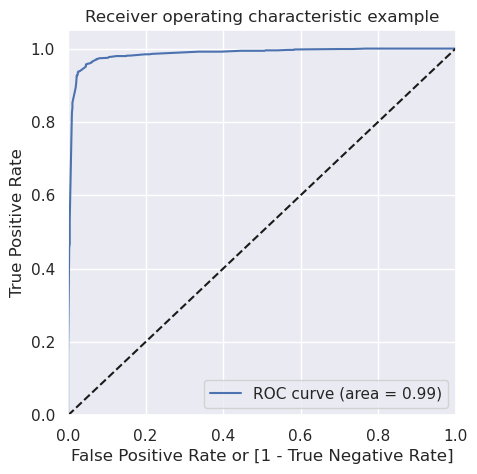

In [34]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [35]:
precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.9602409638554217

0.9556354916067147

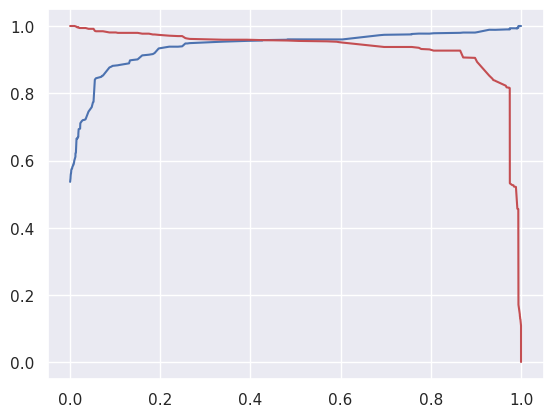

In [36]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)
plt.plot(thresholds, p[:-1], "b-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()